# Initialization

In [4]:
# Import the class to read the file galaxies.hdf5
from GalformRun_basic import * 
import pandas as pd

%matplotlib inline
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rcParams.update({'font.size': 20})

import time
import eagleSqlTools as egl
con = egl.connect(user="giorgio",password='BN401kmd') 

In [5]:
# Create an instance of the class GalformRun 
# in order to use functins like .get() and .magnitude()
g = GalformRun('/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol0/')

In [6]:
# example of how to get the rest-frame V magnitude 
g.magnitude("V_r",1.1734,extinction=True)

array([-16.33772 , -18.87405 , -14.796329, ..., -11.372037, -12.46811 ,
       -13.917074], dtype=float32)

# VIOLETTA ALL GALAXIES

# Download from VIRGO snaps 37 and 47 and save into txt files in COSMA

## Snapshot = 37

In [30]:
Q = 'SELECT SDSS_u_ext,mag_V_ext, SDSS_i_obs_ext '  
Q += 'FROM Gonzalez2014a..mr7 '
Q += 'WHERE snapnum=37'

t1 = time.time()
ALL_GALAXIES_37 = egl.execute_query(con,Q)
t2 = time.time()

In [48]:
print(t2-t1," seconds")

301.9414653778076  seconds


In [45]:
ALL37 = pd.DataFrame(ALL_GALAXIES_37)

In [46]:
ALL37.to_csv('./txt_data/ALL_GALAXIES_37.txt',sep=' ')

## Snapshot = 47

In [49]:
Q = 'SELECT SDSS_u_ext,mag_V_ext, SDSS_i_obs_ext '  
Q += 'FROM Gonzalez2014a..mr7 '
Q += 'WHERE snapnum=47'

t1 = time.time()
ALL_GALAXIES_47 = egl.execute_query(con,Q)
t2 = time.time()
print(t2-t1," seconds")

317.3331735134125  seconds


In [50]:
ALL47 = pd.DataFrame(ALL_GALAXIES_47)

In [51]:
t1 = time.time()
ALL47.to_csv('./txt_data/ALL_GALAXIES_47.txt',sep=' ')
t2 = time.time()
print(t2-t1," seconds")

173.4451880455017  seconds


# Read from txt file 

In [7]:
ALL37 = pd.read_csv('./txt_data/ALL_GALAXIES_37.txt',sep=' ',index_col=0)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
ALL47 = pd.read_csv('./txt_data/ALL_GALAXIES_47.txt',sep=' ',index_col=0)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Check Plot: Luminosity function Violetta

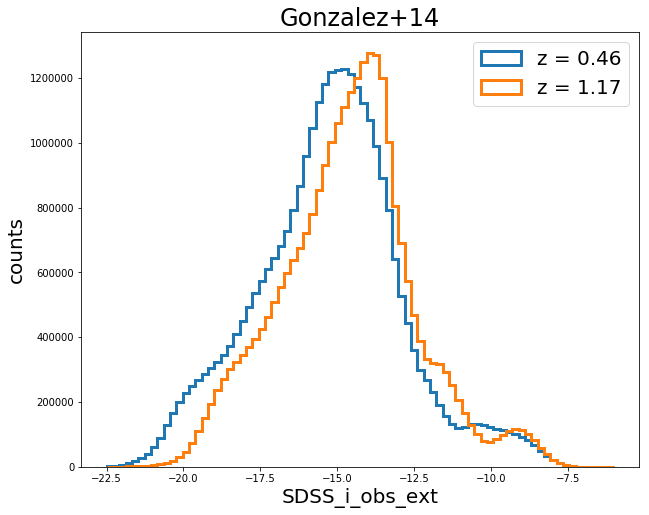

In [9]:
plt.figure(figsize=(10,8))
plt.hist(ALL47['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='z = 0.46')
plt.hist(ALL37['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='z = 1.17')
plt.xlabel('SDSS_i_obs_ext')
plt.ylabel('counts')
plt.title('Gonzalez+14')
plt.legend()
#plt.savefig('./plots/Violetta_luminosity_function.png')
plt.show()

# COSMOLOGY

In [10]:
def integ_trap(func,z1,z2,N=1000):
    z = np.logspace(np.log10(z1),np.log10(z2),N)
    y = func(z)

    A = 0
    for i in range(len(z)-1):
        A += np.abs((z[i+1]-z[i]))*(y[i]+y[i+1])/2
    return A

def E(z,Om_rad=8.4*10**(-5),Om_lambda=0.7,Om_mat=0.3):
    return np.sqrt(Om_rad*(1+z)**4 + Om_mat*(1+z)**3 + Om_lambda)

def over_E(z):
    return E(z)**(-1)

def comoving_distance(z):
    zero = 10**(-20)
    c = 3e5 #km/s
    H0=100. #km/s/Mpc
    return (c*H0**(-1)*integ_trap(over_E,zero,z,10**(3))) #Mpc h^-1

vec_r = np.vectorize(comoving_distance)

def Luminosity_distance(z):
    '''Returns the Luminosity distance in units of Mpc h^-1'''
    return comoving_distance(z)*(1.+z)

def ABSOLUTE_MAGNITUDE_minus5logh(m,z,K_correction=False,ratio_L=1.):
    if K_correction:
        return m -25. -5.*np.log10(Luminosity_distance(z)) -2.5*np.log10(ratio_L*(1.+z))
    else:
        return m -25. -5.*np.log10(Luminosity_distance(z))

vec_ABSOLUTE_MAGNITUDE_minus5logh = np.vectorize(ABSOLUTE_MAGNITUDE_minus5logh)

# EDGE

In [11]:
def EDGE(x,y,x_min=-26.,x_max=-15.,x_bin_size=0.1,y_min=0.55,y_max=2.1,y_bin_size=0.15,threashold =0.15):
    '''It returns two arrays containing the x and y of the edge'''
    y_Nbins = int((y_max - y_min) / y_bin_size)
    x_Nbins = int((x_max - x_min) / x_bin_size)
    x_edge=[]
    y_edge=[]
    #loop on y bins
    for i in range(y_Nbins):
        # define y bin
        y_low = y_min + y_bin_size * i
        y_high = y_min + y_bin_size * (i+1)
        y_center = (y_low+y_high)/2.
        select_y_in_ybin = np.where((y>=y_low)&(y<y_high))
        # histogram of x in a selected y bin
        x_histo, x_histo_bins = np.histogram(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max))
        #find most populated bin
        x_histo_max = np.max(x_histo[:-1])
        x_histo_max_index = np.argmax(x_histo[:-1])
        #loop to find the edge
        for j in range(x_histo_max_index,0,-1):
            if (x_histo[j]<x_histo_max * threashold):
                edge_index = j
                break
        x_edge.append(x_histo_bins[j])
        y_edge.append(y_center)
    return np.array(x_edge), np.array(y_edge)

# alternative to keep fix the number of points

In [12]:
def EDGE_fixed_Npoints(x,y,x_min=-26.,x_max=-15.,x_bin_size=0.1,y_min=0.55,y_max=2.1,y_Nbins=15,y_points_per_bin=400,threashold =0.15):
    '''It returns two arrays containing the x and y of the edge'''
    print('Computing...')
    print('colour_bin \t bin_size')
    #y_Nbins = int((y_max - y_min) / y_bin_size)
    
    y_bin_step = float((y_max - y_min) / y_Nbins)
    
    x_Nbins = int((x_max - x_min) / x_bin_size)
    x_edge=[]
    y_edge=[]
    
    #loop on y bins
    for i in range(y_Nbins):
        y_center  = y_min + y_bin_step * i
        # define the y bin which contains at least y_points_per bin
        
        select_y_in_ybin = [[]]
        y_epsilon= 0.000
        while (len(select_y_in_ybin[0])<y_points_per_bin): 
            y_epsilon = y_epsilon + 0.005
            y_low = y_center-y_epsilon
            y_high = y_center+y_epsilon
        
            select_y_in_ybin = np.where((y>=y_low)&(y<y_high))
        print(round(y_center,2),"\t",y_epsilon*2)      
        # histogram of x in a selected y bin
        x_histo, x_histo_bins = np.histogram(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max))
        #find most populated bin
        x_histo_max = np.max(x_histo[:-1])
        x_histo_max_index = np.argmax(x_histo[:-1])
        #loop to find the edge
        for j in range(x_histo_max_index,0,-1):
            if (x_histo[j]<x_histo_max * threashold):
                edge_index = j
                break
        x_edge.append(x_histo_bins[j])
        y_edge.append(y_center)
    print('...done.')
    return np.array(x_edge), np.array(y_edge)

# Galform Run (Giorgio)

# Write Galform output in txt files (you don't want to do it again)

Do not do it!!!

Not even by mistake

In [32]:
def Create_data(volume=0,snap=37,zsnap=1.1734,feedback=True):
    '''Function to read the output of Galform and write it in a txt file in the folder ./txt_data'''
    #create right path
    if feedback: 
        fb = 'gp14'
        fb_save = 'feedback'
    else: 
        fb = 'gp14.nofeedback'
        fb_save= 'nofeedback'
        
    path = '/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/'+fb+'/iz'+str(snap)+'/ivol'+str(volume)+'/'
    #path= '../data/uvi'+str(snap)+'_'+fb+'_vol'+str(volume)+'.txt'
    print(path)
    #read data from galaxies.hdf5 using the class GalformRun
    G = GalformRun(path)
    #u = np.array(G.get("mag_SDSS-u_r_tot_ext",1.1734))
    u = np.array(G.magnitude("SDSS-u_r",zsnap,extinction=True))
    #v = np.array(G.get("mag_V_r_tot_ext",zsnap))
    v = np.array(G.magnitude("V_r",zsnap,extinction=True))
    #i = np.array(G.get("mag_SDSS-i_o_tot_ext",zsnap))
    i = np.array(G.magnitude("SDSS-i_o",zsnap,extinction=True))
    #crete pandas dataframe with data
    df = pd.DataFrame(data={'u':u , 'v':v , 'i':i})
    #save dataframe in a txt file
    df.to_csv('./txt_data/uvi'+str(snap)+'_'+fb_save+'_vol'+str(volume)+'.txt',index=None,sep=' ')
    return u,v,i

In [33]:
# Read and write in txt all the volumes at z = 1.17 with AGN feedback activated
for i in range(10):
    Create_data(volume=i,snap=37,zsnap=1.1734,feedback=True)

/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol0/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol1/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol2/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol3/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol4/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol5/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol6/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol7/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol8/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz37/ivol9/


In [34]:
# Read and write in txt all the volumes at z = 0.46 with AGN feedback activated
for i in range(10):
    Create_data(volume=i,snap=47,zsnap=0.456,feedback=True)

/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol0/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol1/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol2/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol3/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol4/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol5/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol6/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol7/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol8/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14/iz47/ivol9/


In [35]:
# Read and write in txt all the volumes at z = 1.17 with AGN feedback off
for i in range(10):
    Create_data(volume=i,snap=37,zsnap=1.1734,feedback=False)

/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol0/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol1/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol2/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol3/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol4/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol5/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol6/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol7/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol8/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz37/ivol9/


In [36]:
# Read and write in txt all the volumes at z = 0.46 with AGN feedback off
for i in range(10):
    Create_data(volume=i,snap=47,zsnap=0.456,feedback=False)

/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol0/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol1/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol2/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol3/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol4/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol5/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol6/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol7/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol8/
/data/dega2/dc-manz2/Galform_Out/v2.7.0/stable/MillGas/gp14.nofeedback/iz47/ivol9/


# Read from txt and add subvolumes

In [13]:
def Add_subvolumes(snap=47,feedback=False):
    '''Read all the subvolumes (0 to 9) for the specified snapshot and for the specified AGN feedback scenario'''
    u_tot = []
    v_tot = []
    i_tot = []
    for i_vol in range(10):
        
        if feedback: 
            fb_save = 'feedback'
        else: 
            fb_save= 'nofeedback'
        
        data = pd.read_csv('./txt_data/uvi'+str(snap)+'_'+fb_save+'_vol'+str(i_vol)+'.txt',delimiter=' ')
        #print(data['u'][0])

        
        u_tot = np.concatenate((u_tot,data['u']))
        v_tot = np.concatenate((v_tot,data['v']))
        i_tot = np.concatenate((i_tot,data['i']))

        
        print(len(u_tot))
        
    return u_tot,v_tot,i_tot

In [14]:
u47_tot_feed, v47_tot_feed, i47_tot_feed = Add_subvolumes(snap=47,feedback=True)

444878
900149
1346992
1798164
2257506
2698382
3157117
3608891
4055006
4497868


In [15]:
u37_tot_feed, v37_tot_feed, i37_tot_feed = Add_subvolumes(snap=37,feedback=True)

411714
833680
1246479
1664890
2091306
2498490
2925176
3344178
3756543
4166102


In [16]:
u47_tot_nofeed, v47_tot_nofeed, i47_tot_nofeed = Add_subvolumes(snap=47,feedback=False)

444878
900149
1346993
1798165
2257507
2698383
3157117
3608891
4055006
4497868


In [17]:
u37_tot_nofeed, v37_tot_nofeed, i37_tot_nofeed = Add_subvolumes(snap=37,feedback=False)

411714
833680
1246480
1664891
2091307
2498491
2925176
3344178
3756543
4166102


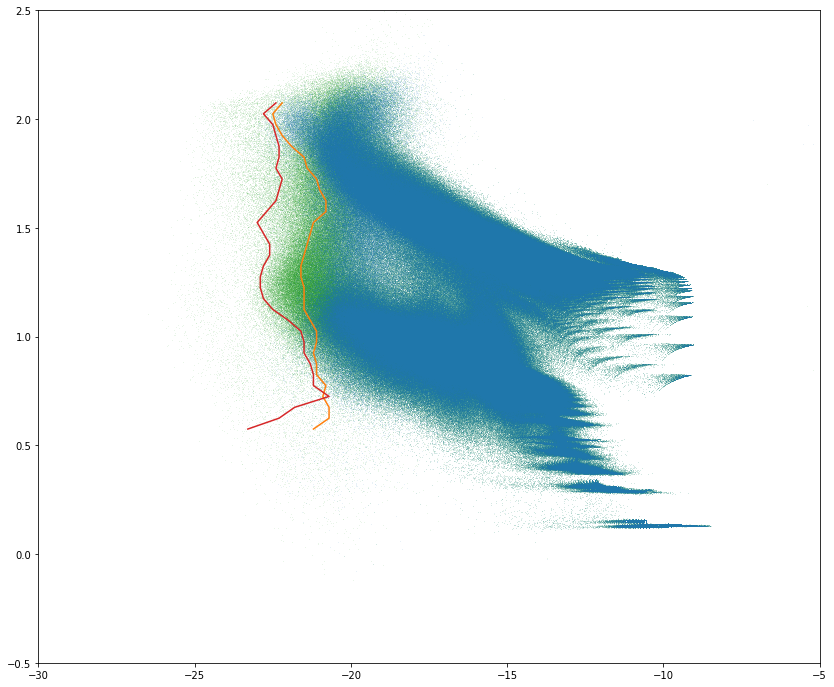

In [18]:
plt.figure(figsize=(14,12))
plt.ylim(-0.5,2.5)
plt.xlim(-30,-5)
plt.plot(v47_tot_feed,u47_tot_feed-v47_tot_feed,",",alpha=0.1,zorder=1)
plt.plot(EDGE(v47_tot_feed,u47_tot_feed-v47_tot_feed,y_bin_size=0.05,x_max=-19,threashold=0.1)[0],
         EDGE(v47_tot_feed,u47_tot_feed-v47_tot_feed,y_bin_size=0.05,x_max=-19,threashold=0.1)[1])
##plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,",",alpha=0.7)
plt.plot(v47_tot_nofeed,u47_tot_nofeed-v47_tot_nofeed,",",alpha=0.1,zorder=-1)
plt.plot(EDGE(v47_tot_nofeed,u47_tot_nofeed-v47_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[0],
         EDGE(v47_tot_nofeed,u47_tot_nofeed-v47_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[1])
##plt.plot(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,",",alpha=0.7)
plt.show()

Computing...
0.12999999999999998
0.060000000000000005
0.02
0.02
0.02
0.060000000000000005
0.08
0.03
0.02
0.04
0.08
0.12999999999999998
0.21000000000000005
0.3100000000000001
0.48000000000000026
...done.
Computing...
0.12999999999999998
0.060000000000000005
0.02
0.02
0.02
0.05
0.07
0.03
0.02
0.04
0.09999999999999999
0.16
0.24000000000000007
0.36000000000000015
0.5200000000000002
...done.


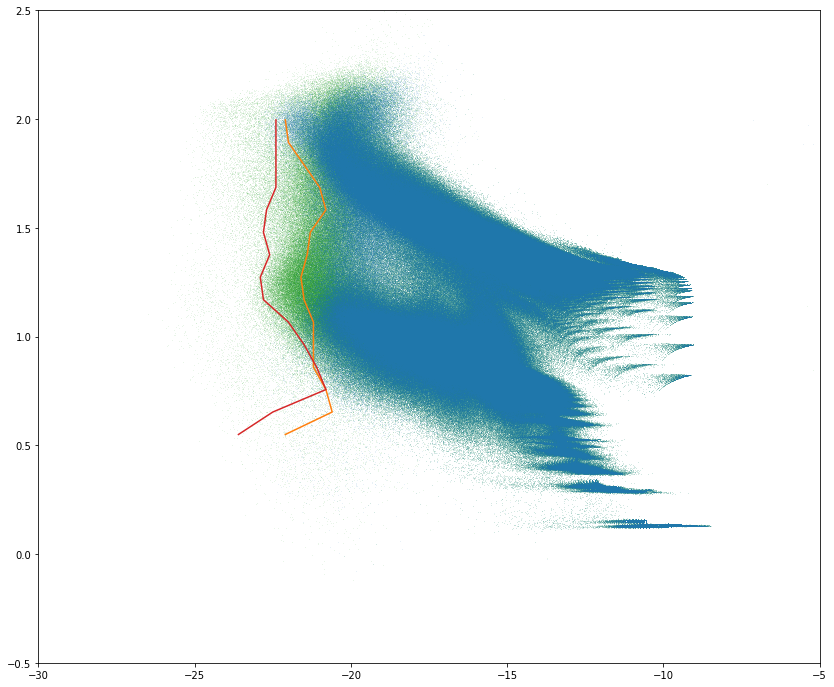

In [56]:
plt.figure(figsize=(14,12))
plt.ylim(-0.5,2.5)
plt.xlim(-30,-5)
plt.plot(v47_tot_feed,u47_tot_feed-v47_tot_feed,",",alpha=0.1,zorder=1)
e1,e2 = EDGE_fixed_Npoints(v47_tot_feed,u47_tot_feed-v47_tot_feed,y_Nbins=15,y_points_per_bin=100000,x_max=-19,threashold=0.1)
plt.plot(e1,e2,"-",markersize=7)
##plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,",",alpha=0.7)
plt.plot(v47_tot_nofeed,u47_tot_nofeed-v47_tot_nofeed,",",alpha=0.1,zorder=-1)
ee1,ee2 = EDGE_fixed_Npoints(v47_tot_nofeed,u47_tot_nofeed-v47_tot_nofeed,y_Nbins=15,y_points_per_bin=100000,x_max=-19,threashold=0.1) 
plt.plot(ee1,ee2,"-",markersize=7)
##plt.plot(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,",",alpha=0.7)
plt.show()

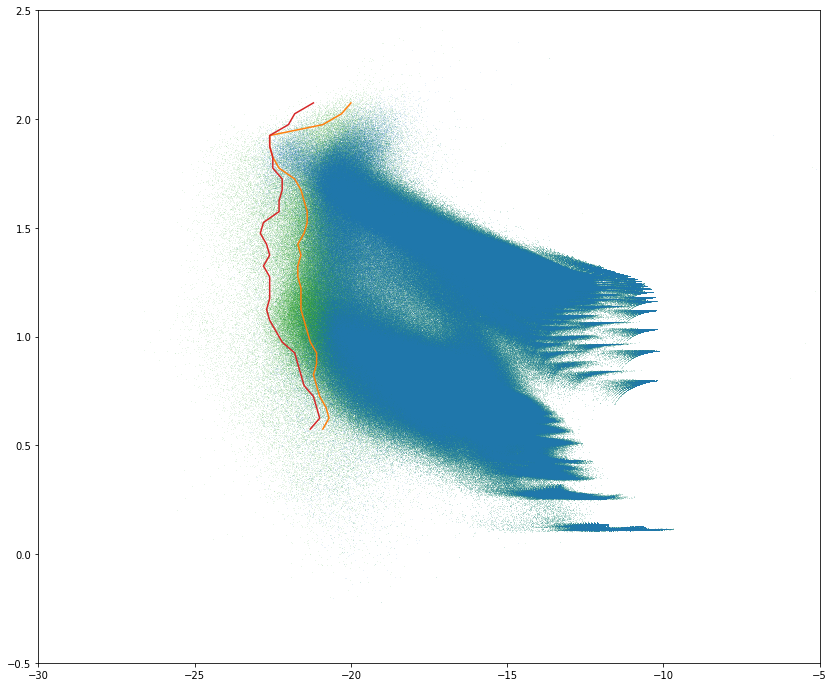

In [17]:
plt.figure(figsize=(14,12))
plt.ylim(-0.5,2.5)
plt.xlim(-30,-5)
plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,",",alpha=0.1,zorder=1)
plt.plot(EDGE(v37_tot_feed,u37_tot_feed-v37_tot_feed,y_bin_size=0.05,x_max=-19,threashold=0.1)[0],
         EDGE(v37_tot_feed,u37_tot_feed-v37_tot_feed,y_bin_size=0.05,x_max=-19,threashold=0.1)[1])
##plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,",",alpha=0.7)
plt.plot(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,",",alpha=0.1,zorder=-1)
plt.plot(EDGE(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[0],
         EDGE(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,y_bin_size=0.05,x_max=-19,threashold=0.1)[1])
##plt.plot(v37_tot_nofeed,u37_tot_nofeed-v37_tot_nofeed,",",alpha=0.7)
plt.show()

# Cut at 22.5

In [19]:
print('i_AB =22.5 means I_AB of:')
print(ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734),' @ z = 1.17')
print(ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.465),' @ z = 0.46')

i_AB =22.5 means I_AB of:
-21.256565734819656  @ z = 1.17
-18.79942677774084  @ z = 0.46


# My feedback

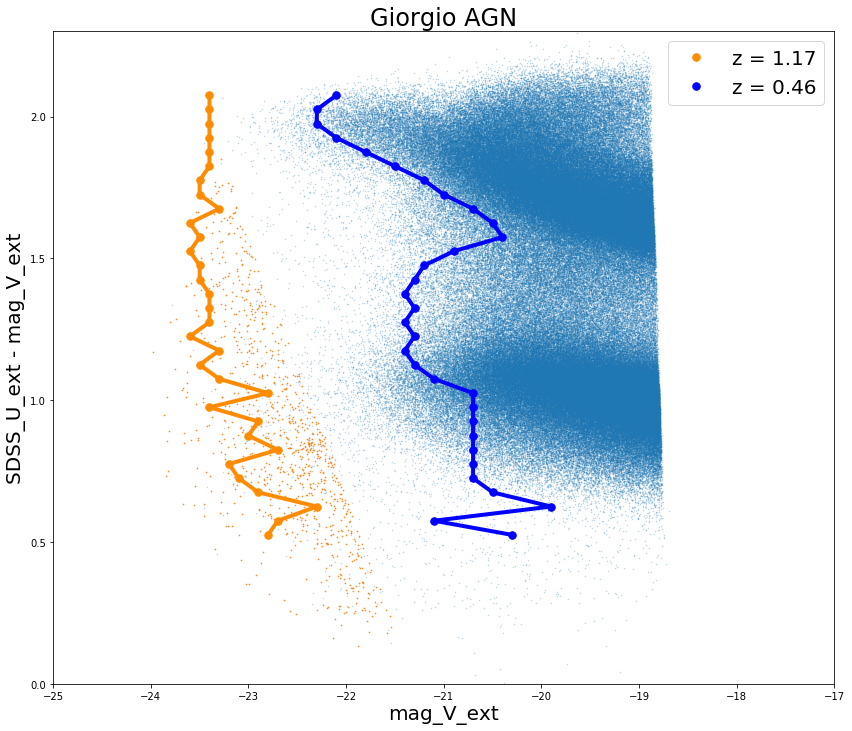

In [20]:
plt.figure(figsize=(14,12))
plt.ylim(-0.5,2.5)
plt.xlim(-30,-5)

# snapshot 37 (z=1.17)
sec37_gio= np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734))
plt.plot(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],".",alpha=0.9,zorder=1,color='C1',markersize=1.3)
plt.plot(EDGE(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[0],
         EDGE(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[1],
        lw=4,color='darkorange')
plt.plot(EDGE(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[0],
         EDGE(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[1],
        ".",markersize=15,color='darkorange',label='z = 1.17')

# snapshot 47 (z=0.46)
sec47_gio = np.where(i47_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))
plt.plot(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],".",alpha=1.3,zorder=-1,color='C0',markersize=1.)
plt.plot(EDGE(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[0],
         EDGE(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[1],
        lw=4,color='blue')
plt.plot(EDGE(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[0],
         EDGE(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],y_min=0.5,y_bin_size=0.05,x_max=-15,x_bin_size=0.1,threashold=0.15)[1],
        ".",markersize=15,color='blue',label='z = 0.46')

plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.title('Giorgio AGN')

plt.xlim(-25.,-17.)
plt.ylim(0.,2.3)


plt.legend()
plt.show()

# My feedback alternative edge

Computing...
colour_bin 	 bin_size
0.4 	 0.18000000000000002
0.46 	 0.16
0.51 	 0.11999999999999998
0.57 	 0.09
0.63 	 0.09
0.68 	 0.07
0.74 	 0.060000000000000005
0.8 	 0.07
0.85 	 0.05
0.91 	 0.08
0.97 	 0.09
1.02 	 0.09999999999999999
1.08 	 0.11999999999999998
1.14 	 0.13999999999999999
1.19 	 0.15
1.25 	 0.15
1.31 	 0.16
1.36 	 0.13999999999999999
1.42 	 0.18000000000000002
1.48 	 0.23000000000000007
1.53 	 0.2700000000000001
1.59 	 0.3300000000000001
1.65 	 0.4100000000000002
1.7 	 0.5200000000000002
1.76 	 0.6400000000000003
1.82 	 0.7500000000000004
1.87 	 0.8600000000000005
1.93 	 0.9800000000000006
1.99 	 1.0900000000000007
2.04 	 1.2000000000000008
...done.
Computing...
colour_bin 	 bin_size
0.6 	 0.18000000000000002
0.65 	 0.09999999999999999
0.7 	 0.04
0.75 	 0.02
0.8 	 0.01
0.85 	 0.01
0.9 	 0.01
0.95 	 0.01
1.0 	 0.01
1.05 	 0.01
1.1 	 0.01
1.15 	 0.01
1.2 	 0.01
1.25 	 0.01
1.3 	 0.01
1.35 	 0.01
1.4 	 0.01
1.45 	 0.01
1.5 	 0.01
1.55 	 0.01
1.6 	 0.01
1.65 	 0.01
1.7 	

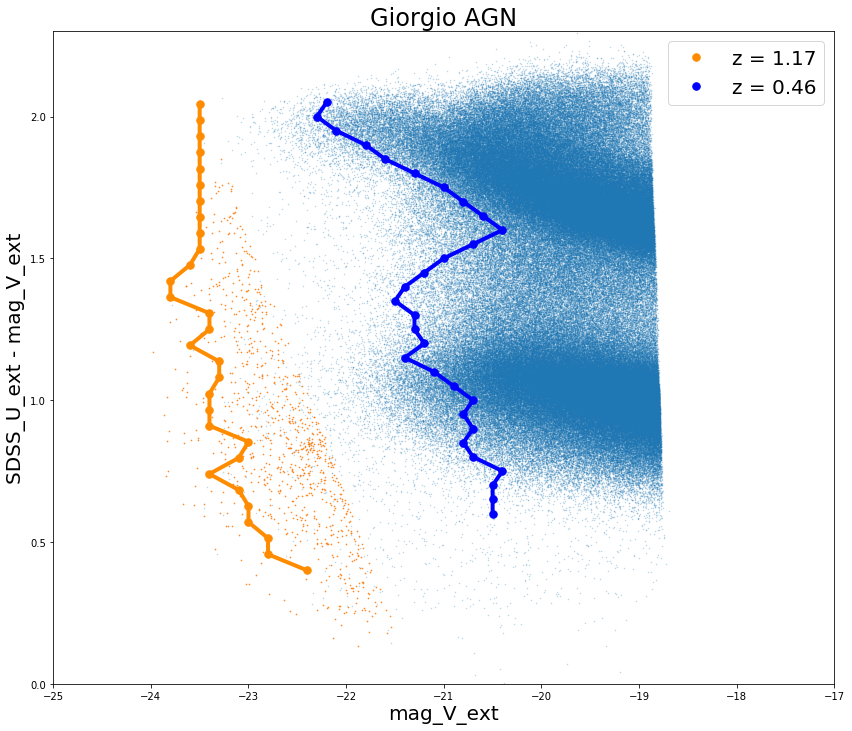

In [21]:
plt.figure(figsize=(14,12))
plt.ylim(-0.5,2.5)
plt.xlim(-30,-5)

# snapshot 37 (z=1.17)
sec37_gio= np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734))
plt.plot(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],".",alpha=0.9,zorder=1,color='C1',markersize=1.3)
e37_1,e37_2 = EDGE_fixed_Npoints(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],
                                 y_min=0.4,
                                 y_points_per_bin=70,
                                 y_Nbins=30,
                                 x_max=-15,
                                 x_bin_size=0.1,
                                 threashold=0.15)
plt.plot(e37_1,e37_2,lw=4,color='darkorange')
plt.plot(e37_1,e37_2,".",markersize=15,color='darkorange',label='z = 1.17')

# snapshot 47 (z=0.46)
sec47_gio = np.where(i47_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))
plt.plot(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],".",alpha=1.3,zorder=-1,color='C0',markersize=1.)

e47_1, e47_2 = EDGE_fixed_Npoints(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],
                                  y_min=0.6,
                                  y_points_per_bin=1000,
                                  y_Nbins=30,
                                  x_max=-15,
                                  x_bin_size=0.1,
                                  threashold=0.15)
plt.plot(e47_1,e47_2,lw=4,color='blue')
plt.plot(e47_1,e47_2,".",markersize=15,color='blue',label='z = 0.46')

plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.title('Giorgio AGN')

plt.xlim(-25.,-17.)
plt.ylim(0.,2.3)


plt.legend()
plt.show()

In [22]:
# example histo in colour bin

def histo_in_colour_bin(min_col,max_col):
    plt.figure(figsize=(10,8))

    sec47_gio= np.where(i47_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))

    select_colour_bin = np.where(((u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio])<max_col)&((u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio])>min_col))
    plt.hist(v47_tot_feed[sec47_gio][select_colour_bin],bins=int((23-18)/0.1),range=(-23,-18),label=str(min_col)+'<U-V<'+str(max_col))
    #print(int((22-10)/0.1))

    #print(v47_tot_feed[sec47_gio].max())
    
    counts,b = np.histogram(v47_tot_feed[sec47_gio][select_colour_bin],bins=int((22-10)/0.1),range=(-22,-10))

    plt.axvline(b[np.where(counts==np.max(counts))],c='k',lw=3)


    #loop to find the edge
    for j in range(np.argmax(counts),0,-1):
        if (counts[j]<np.max(counts) * 0.15):
            edge_index = j
            break
    plt.axvline(b[j],c='k',lw=3)
    plt.xlabel("mag_V_ext")
    plt.ylabel('counts')
    plt.legend()
    plt.show()

In [23]:
# example histo in colour bin

def histo_in_colour_bin_general(min_col,max_col,u,v,i,redshift,thr=0.15,xbsz=0.1,save=True,path='./plots/image.png'):
    plt.figure(figsize=(10,8))
    
    sec = np.where(i<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=redshift))
    
    select_colour_bin = np.where(((u[sec]-v[sec])<max_col)&((u[sec]-v[sec])>min_col))
    plt.hist(v[sec][select_colour_bin],bins=int((26-18)/xbsz),range=(-26,-18),label=str(min_col)+'<U-V<'+str(max_col))
    #print(int((22-10)/0.1))

    counts,b = np.histogram(v[sec][select_colour_bin],bins=int((26-18)/xbsz),range=(-26,-18))

    #plt.axvline(b[np.where(counts==np.max(counts))],c='k',lw=3)
    plt.axvline(b[np.argmax(counts)],c='k',lw=3)

    #loop to find the edge
    for j in range(np.argmax(counts),0,-1):
        if (counts[j]<np.max(counts) * thr):
            edge_index = j
            break
    plt.axvline(b[j],c='k',lw=3)
    plt.xlabel("mag_V_ext")
    plt.ylabel('counts')
    plt.legend()
    if save:
        plt.savefig(path)
    
    plt.show()

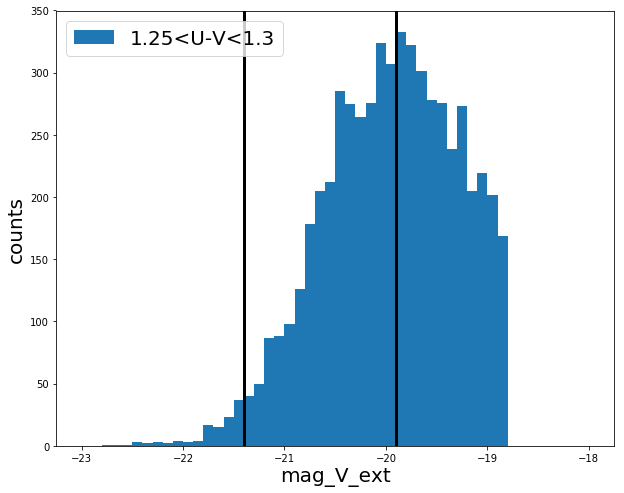

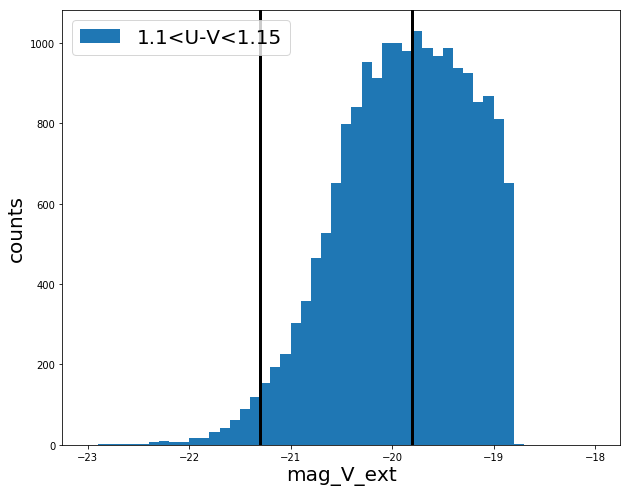

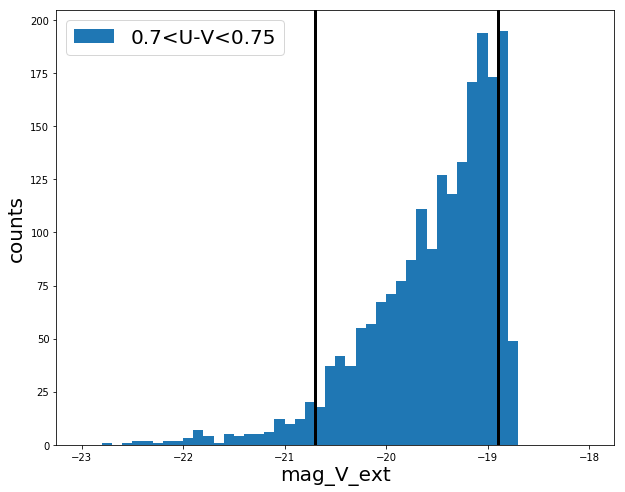

In [24]:
histo_in_colour_bin(min_col=1.25,max_col=1.30)
histo_in_colour_bin(min_col=1.10,max_col=1.15)
histo_in_colour_bin(min_col=0.70,max_col=0.75)

In [25]:
def colmag_cut(v37=v37_tot_feed,
               u37=u37_tot_feed,
               i37=i37_tot_feed,
               v47=v47_tot_feed,
               u47=u47_tot_feed,
               i47=i47_tot_feed,
               title='Giorgio AGN',
               path_fig='./plots/colmag_giorgio_feed.png',
               save_fig=True,
               xbsz=0.1,
               ybsz=0.05,
               thr=0.15):

    plt.figure(figsize=(14,12))
    plt.ylim(-0.5,2.5)
    plt.xlim(-30,-5)

    # snapshot 37 (z=1.17)
    
    sec37= np.where(i37<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734))

    plt.plot(v37[sec37],u37[sec37]-v37[sec37],".",alpha=0.9,zorder=1,color='C1',markersize=1.3)
    
    plt.plot(EDGE(v37[sec37],u37[sec37]-v37[sec37],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[0],
             EDGE(v37[sec37],u37[sec37]-v37[sec37],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[1],
            lw=4,color='darkorange')
    plt.plot(EDGE(v37[sec37],u37[sec37]-v37[sec37],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[0],
             EDGE(v37[sec37],u37[sec37]-v37[sec37],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[1],
            ".",markersize=15,color='darkorange',label='z = 1.17')

    # snapshot 47 (z=0.46)
    print("z =0.46")
    sec47 = np.where(i47<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))
    plt.plot(v47[sec47],u47[sec47]-v47[sec47],".",alpha=0.3,zorder=-1,color='C0',markersize=1.)
    plt.plot(EDGE(v47[sec47],u47[sec47]-v47[sec47],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[0],
             EDGE(v47[sec47],u47[sec47]-v47[sec47],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[1],
            lw=4,color='blue')
    plt.plot(EDGE(v47[sec47],u47[sec47]-v47[sec47],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[0],
             EDGE(v47[sec47],u47[sec47]-v47[sec47],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)[1],
            ".",markersize=15,color='blue',label='z = 0.46')

    plt.xlabel("mag_V_ext")
    plt.ylabel("SDSS_U_ext - mag_V_ext")
    plt.title(title)

    plt.xlim(-26.,-17.)
    plt.ylim(0.,2.3)

    plt.legend()
    if save_fig:
        plt.savefig(path_fig)
    plt.show()

In [26]:
def colmag_cut_ALTERNATIVE(v37=v37_tot_feed,
               u37=u37_tot_feed,
               i37=i37_tot_feed,
               v47=v47_tot_feed,
               u47=u47_tot_feed,
               i47=i47_tot_feed,
               title='Giorgio AGN',
               path_fig='./plots/colmag_giorgio_feed.png',
               save_fig=True,
               xbsz=0.1,
               ybsz=0.05,
               thr=0.15,
               fix_point=False,
               Npoints37=100,
               Npoints47=100,
               N_colour_bins=15,
               contours=True):

    plt.figure(figsize=(14,12))
    plt.ylim(-0.5,2.5)
    plt.xlim(-30,-5)

    # snapshot 37 (z=1.17)
    sec37= np.where(i37<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734))

    plt.plot(v37[sec37],u37[sec37]-v37[sec37],".",alpha=0.9,zorder=1,color='C1',markersize=1.3)
    #plt.hist2d(v37[sec37],u37[sec37]-v37[sec37],bins=60)
    
    
    if (fix_point==False):
        e37_x,e37_y = EDGE(v37[sec37],u37[sec37]-v37[sec37],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)
    else:
        print("z =1.17")
        e37_x,e37_y = EDGE_fixed_Npoints(v37[sec37],u37[sec37]-v37[sec37],y_min=0.6,y_points_per_bin=Npoints37,x_max=-15,x_bin_size=xbsz,threashold=thr,y_Nbins=N_colour_bins)
    
    plt.plot(e37_x,e37_y,lw=4,color='darkorange')
    plt.plot(e37_x,e37_y,".",markersize=15,color='darkorange',label='z = 1.17')

    if contours:
        h37_c, h37_bx, h37_by = np.histogram2d(v37[sec37],u37[sec37]-v37[sec37],bins=10)
        plt.contour(h37_bx[:-1],h37_by[:-1],h37_c.T)
        plt.colorbar(label='z = 1.17')
    

    # snapshot 47 (z=0.46)
    sec47 = np.where(i47<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))
    plt.plot(v47[sec47],u47[sec47]-v47[sec47],".",alpha=0.3,zorder=-1,color='C0',markersize=1.)
    #plt.hist2d(v47[sec47],u47[sec47]-v47[sec47],bins=100)
    
    if (fix_point==False):
        e47_x,e47_y = EDGE(v47[sec47],u47[sec47]-v47[sec47],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)
    else:
        print("z =0.46")
        e47_x,e47_y = EDGE_fixed_Npoints(v47[sec47],u47[sec47]-v47[sec47],y_min=0.6,y_points_per_bin=Npoints47,x_max=-15,x_bin_size=xbsz,threashold=thr,y_Nbins=N_colour_bins)
    
    plt.plot(e47_x,e47_y,lw=4,color='blue')
    plt.plot(e47_x,e47_y,".",markersize=15,color='blue',label='z = 0.46')

    #contours
    if contours:
        h47_c, h47_bx, h47_by = np.histogram2d(v47[sec47],u47[sec47]-v47[sec47],bins=100)
        plt.contour(h47_bx[:-1],h47_by[:-1],h47_c.T)
        plt.colorbar(label='z = 0.46',orientation='horizontal')
    
    plt.xlabel("mag_V_ext")
    plt.ylabel("SDSS_U_ext - mag_V_ext")
    if (fix_point==False):
        plt.title(title)
    else:
        plt.title(title+" (fixed point)")

    plt.xlim(-26.,-17.)
    plt.ylim(0.,2.3)

    plt.legend()
    if save_fig:
        plt.savefig(path_fig)
    plt.show()

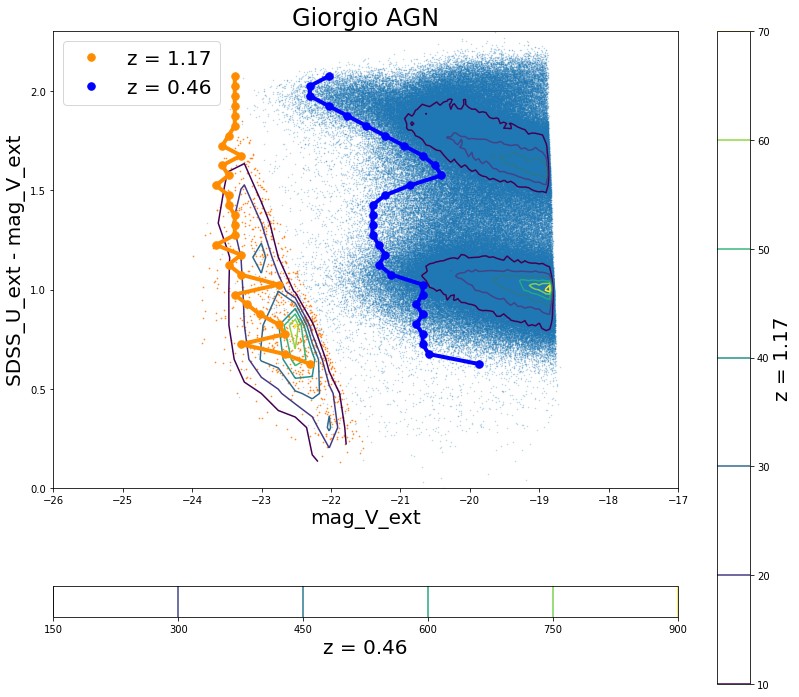

In [27]:
colmag_cut_ALTERNATIVE(v37=v37_tot_feed,
           u37=u37_tot_feed,
           i37=i37_tot_feed,
           v47=v47_tot_feed,
           u47=u47_tot_feed,
           i47=i47_tot_feed,
           title='Giorgio AGN',
           path_fig='./plots/colmag_giorgio_feed.png',
           save_fig=False,
           xbsz=0.09,
           ybsz=0.05,
           thr=0.15,
           fix_point=False,
           contours=True)

z =1.17
Computing...
colour_bin 	 bin_size
0.6 	 0.03
0.67 	 0.03
0.75 	 0.03
0.82 	 0.03
0.9 	 0.04
0.97 	 0.04
1.05 	 0.05
1.12 	 0.08
1.2 	 0.060000000000000005
1.27 	 0.08
1.35 	 0.07
1.42 	 0.07
1.5 	 0.12999999999999998
1.57 	 0.13999999999999999
1.65 	 0.18000000000000002
1.73 	 0.24000000000000007
1.8 	 0.38000000000000017
1.88 	 0.5300000000000002
1.95 	 0.6800000000000004
2.02 	 0.8300000000000005
...done.
z =0.46
Computing...
colour_bin 	 bin_size
0.6 	 0.05
0.67 	 0.01
0.75 	 0.01
0.82 	 0.01
0.9 	 0.01
0.97 	 0.01
1.05 	 0.01
1.12 	 0.01
1.2 	 0.01
1.27 	 0.01
1.35 	 0.01
1.42 	 0.01
1.5 	 0.01
1.57 	 0.01
1.65 	 0.01
1.73 	 0.01
1.8 	 0.01
1.88 	 0.01
1.95 	 0.01
2.02 	 0.01
...done.


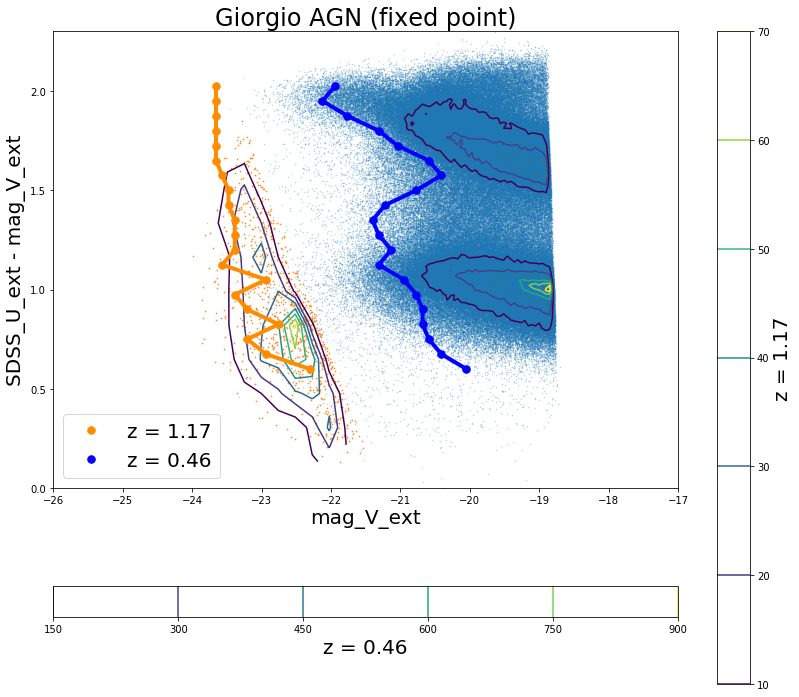

In [28]:
colmag_cut_ALTERNATIVE(v37=v37_tot_feed,
           u37=u37_tot_feed,
           i37=i37_tot_feed,
           v47=v47_tot_feed,
           u47=u47_tot_feed,
           i47=i47_tot_feed,
           title='Giorgio AGN',
           path_fig='./plots/colmag_giorgio_feed_count_fix170.png',
           save_fig=False,
           xbsz=0.09,
           ybsz=0.05,
           thr=0.15,
           fix_point=True,
           Npoints37=30,
           Npoints47=170,
           N_colour_bins=20)

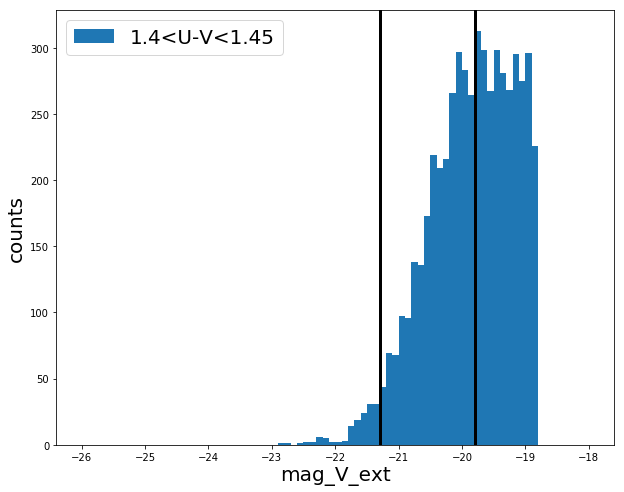

In [25]:
histo_in_colour_bin_general(min_col=1.40,
                            max_col=1.45,
                            v=np.array(v47_tot_feed),
                            u=np.array(u47_tot_feed),
                            i=np.array(i47_tot_feed),
                            redshift=0.456,
                            xbsz=0.1,
                            thr=0.15)

z =1.17
Computing...
colour_bin 	 bin_size
0.6 	 0.03
0.67 	 0.03
0.75 	 0.03
0.82 	 0.02
0.9 	 0.02
0.97 	 0.02
1.05 	 0.02
1.12 	 0.02
1.2 	 0.03
1.27 	 0.04
1.35 	 0.03
1.42 	 0.03
1.5 	 0.03
1.57 	 0.03
1.65 	 0.04
1.73 	 0.04
1.8 	 0.05
1.88 	 0.09999999999999999
1.95 	 0.24000000000000007
2.02 	 0.3900000000000002
...done.
z =0.46
Computing...
colour_bin 	 bin_size
0.6 	 0.03
0.67 	 0.01
0.75 	 0.01
0.82 	 0.01
0.9 	 0.01
0.97 	 0.01
1.05 	 0.01
1.12 	 0.01
1.2 	 0.01
1.27 	 0.01
1.35 	 0.01
1.42 	 0.01
1.5 	 0.01
1.57 	 0.01
1.65 	 0.01
1.73 	 0.01
1.8 	 0.01
1.88 	 0.01
1.95 	 0.01
2.02 	 0.01
...done.


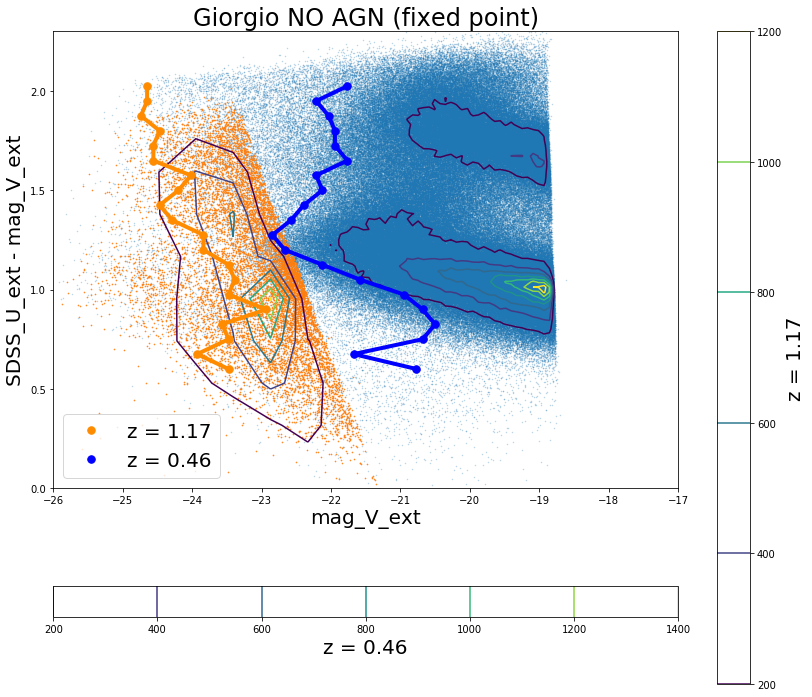

In [26]:
colmag_cut_ALTERNATIVE(v37=v37_tot_nofeed,
           u37=u37_tot_nofeed,
           i37=i37_tot_nofeed,
           v47=v47_tot_nofeed,
           u47=u47_tot_nofeed,
           i47=i47_tot_nofeed,
           title='Giorgio NO AGN',
           path_fig='./plots/colmag_giorgio_nofeed_count_fix170.png',
           save_fig=False,
           xbsz=0.09,
           ybsz=0.05,
           thr=0.15,
           fix_point=True,
           Npoints37=170,
           Npoints47=170,
           N_colour_bins=20,
           contours=True)

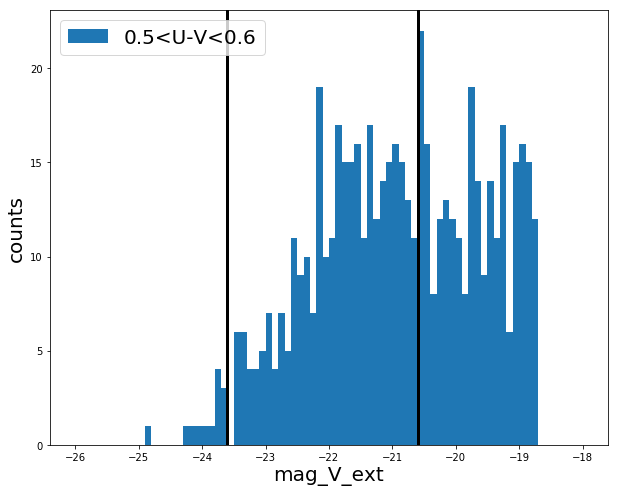

In [31]:
histo_in_colour_bin_general(min_col=0.5,
                            max_col=0.6,
                            v=np.array(v47_tot_nofeed),
                            u=np.array(u47_tot_nofeed),
                            i=np.array(i47_tot_nofeed),
                            redshift=0.456,
                            xbsz=0.1,
                            thr=0.15)

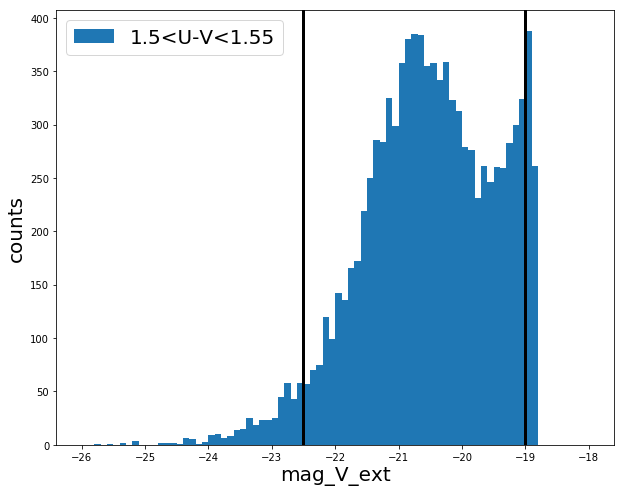

In [32]:
histo_in_colour_bin_general(min_col=1.50,
                            max_col=1.55,
                            v=np.array(v47_tot_nofeed),
                            u=np.array(u47_tot_nofeed),
                            i=np.array(i47_tot_nofeed),
                            redshift=0.456,
                            xbsz=0.1,
                            thr=0.15)

z =1.17
Computing...
colour_bin 	 bin_size
0.6 	 0.04
0.67 	 0.03
0.75 	 0.03
0.82 	 0.03
0.9 	 0.02
0.97 	 0.03
1.05 	 0.05
1.12 	 0.060000000000000005
1.2 	 0.05
1.27 	 0.060000000000000005
1.35 	 0.07
1.42 	 0.08
1.5 	 0.09999999999999999
1.57 	 0.10999999999999999
1.65 	 0.12999999999999998
1.73 	 0.18000000000000002
1.8 	 0.3000000000000001
1.88 	 0.45000000000000023
1.95 	 0.6000000000000003
2.02 	 0.7500000000000004
...done.
z =0.46
Computing...
colour_bin 	 bin_size
0.6 	 0.01
0.67 	 0.01
0.75 	 0.01
0.82 	 0.01
0.9 	 0.01
0.97 	 0.01
1.05 	 0.01
1.12 	 0.01
1.2 	 0.01
1.27 	 0.01
1.35 	 0.01
1.42 	 0.01
1.5 	 0.01
1.57 	 0.01
1.65 	 0.01
1.73 	 0.01
1.8 	 0.01
1.88 	 0.01
1.95 	 0.01
2.02 	 0.01
...done.


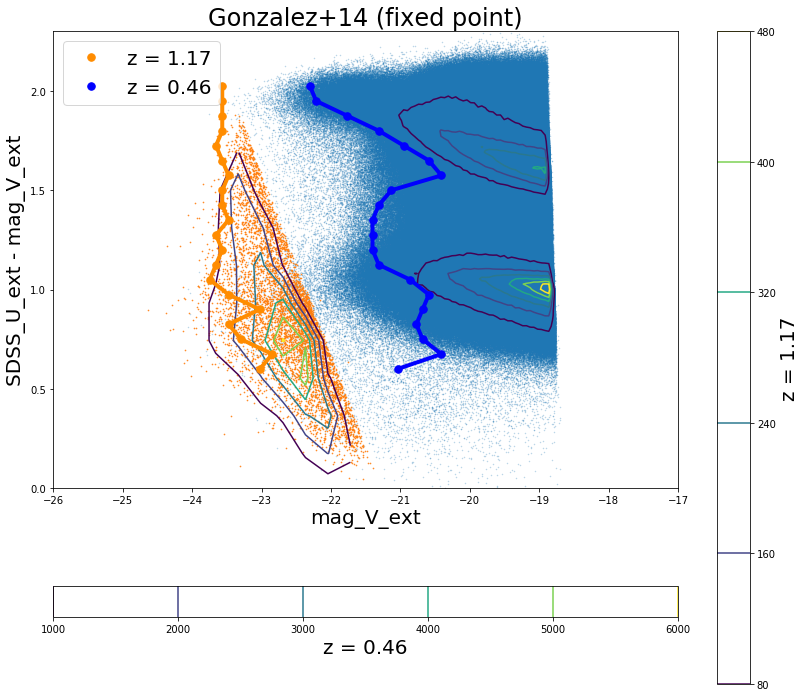

In [28]:
colmag_cut_ALTERNATIVE(v37=np.array(ALL37['mag_V_ext']),
           u37=np.array(ALL37['SDSS_u_ext']),
           i37=np.array(ALL37['SDSS_i_obs_ext']),
           v47=np.array(ALL47['mag_V_ext']),
           u47=np.array(ALL47['SDSS_u_ext']),
           i47=np.array(ALL47['SDSS_i_obs_ext']),
           title='Gonzalez+14',
           path_fig='./plots/colmag_violetta_count_fix170.png',
           save_fig=True,
           xbsz=0.09,
           ybsz=0.06,
           thr=0.15,
           fix_point=True,
           Npoints37=170,
           Npoints47=170,
           N_colour_bins=20,
           contours=True)

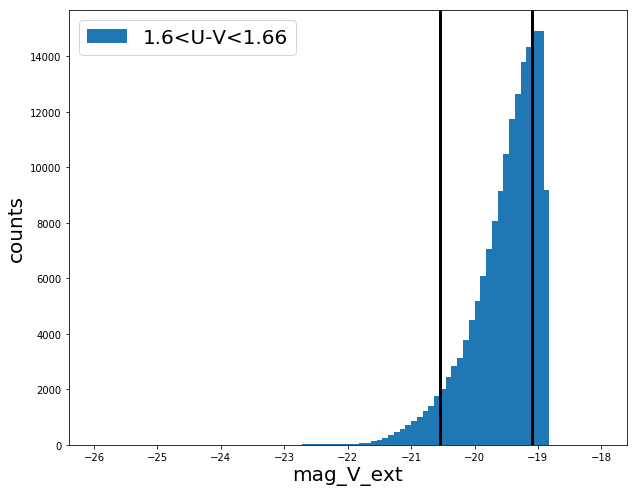

In [32]:
histo_in_colour_bin_general(min_col=1.60,
                            max_col=1.66,
                            v=np.array(ALL47['mag_V_ext']),
                            u=np.array(ALL47['SDSS_u_ext']),
                            i=np.array(ALL47['SDSS_i_obs_ext']),
                            redshift=0.456,
                            xbsz=0.09,
                            thr=0.15,
                            path='./plots/gonzalez_histo_160_166.png')

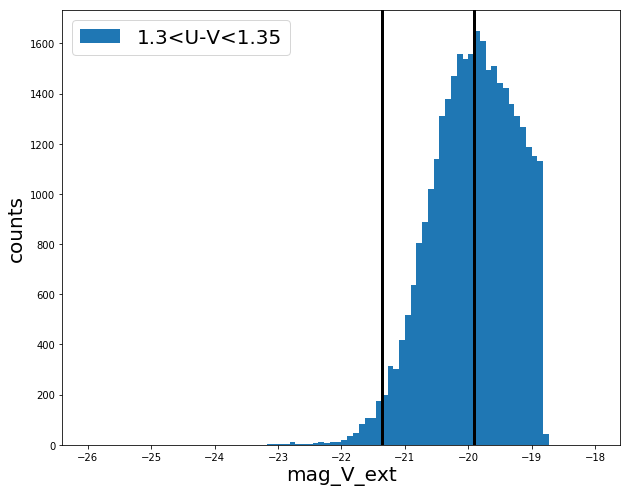

In [146]:
histo_in_colour_bin_general(min_col=1.30,
                            max_col=1.35,
                            v=np.array(ALL47['mag_V_ext']),
                            u=np.array(ALL47['SDSS_u_ext']),
                            i=np.array(ALL47['SDSS_i_obs_ext']),
                            redshift=0.456,
                            xbsz=0.09,
                            thr=0.15)

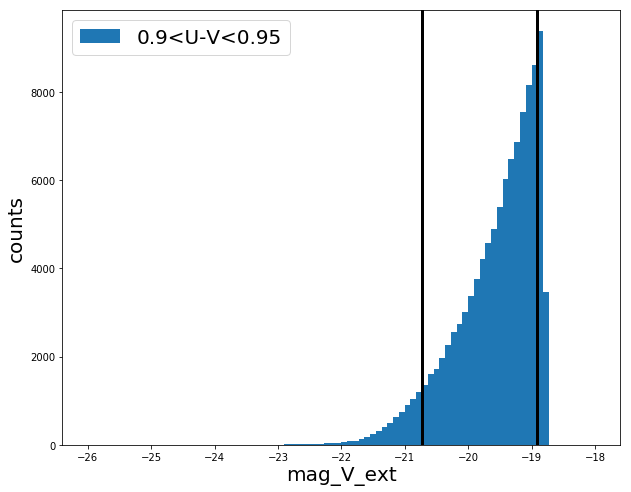

In [169]:
histo_in_colour_bin_general(min_col=0.9,
                            max_col=0.95,
                            v=np.array(ALL47['mag_V_ext']),
                            u=np.array(ALL47['SDSS_u_ext']),
                            i=np.array(ALL47['SDSS_i_obs_ext']),
                            redshift=0.456,
                            xbsz=0.09,
                            thr=0.15)

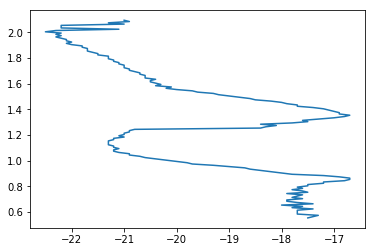

In [21]:
x,y = EDGE(v47_tot_feed,u47_tot_feed-v47_tot_feed,y_bin_size=0.01)

plt.plot(x,y)
plt.show()

# Luminosity function

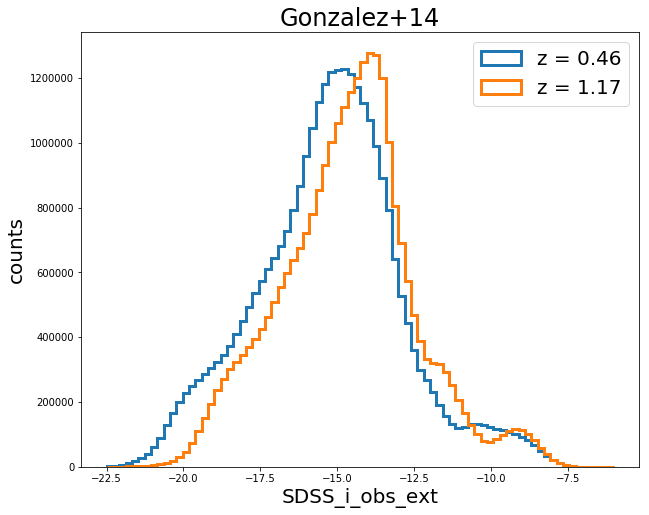

In [22]:
plt.figure(figsize=(10,8))
plt.hist(ALL47['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='z = 0.46')
plt.hist(ALL37['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='z = 1.17')
plt.xlabel('SDSS_i_obs_ext')
plt.ylabel('counts')
plt.title('Gonzalez+14')
plt.legend()
plt.savefig('./plots/Violetta_luminosity_function.png')
plt.show()

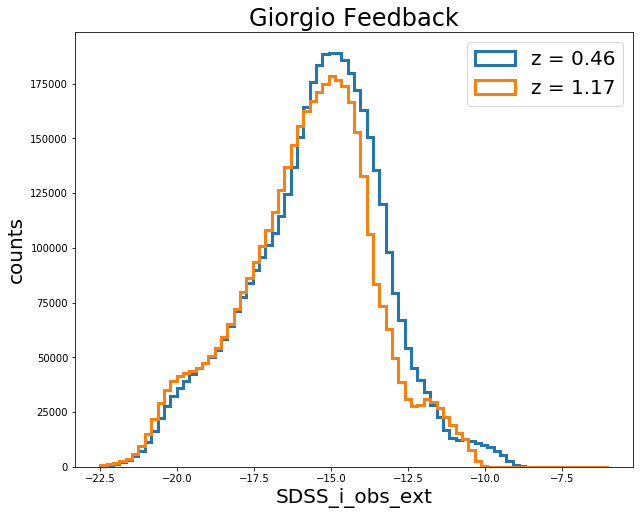

In [23]:
plt.figure(figsize=(10,8))
plt.hist(v47_tot_feed,bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='z = 0.46')
plt.hist(v37_tot_feed,bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='z = 1.17')
plt.xlabel('SDSS_i_obs_ext')
plt.ylabel('counts')
plt.title('Giorgio Feedback')
plt.legend()
plt.savefig('./plots/Giorgio_luminosity_function.png')
plt.show()

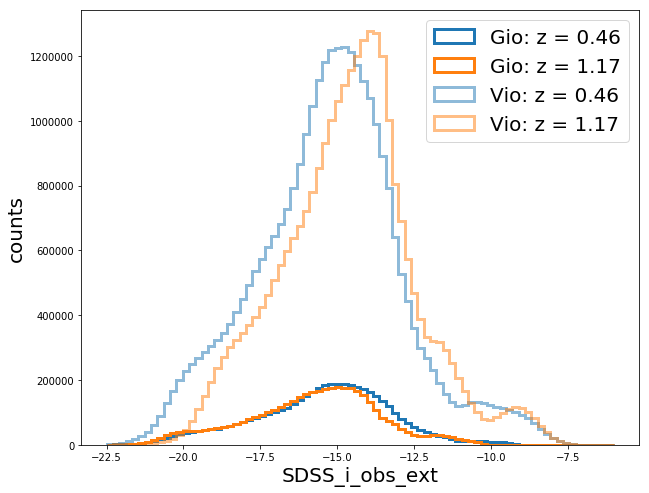

In [24]:
plt.figure(figsize=(10,8))
plt.hist(v47_tot_feed,bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='Gio: z = 0.46')
plt.hist(v37_tot_feed,bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='Gio: z = 1.17')
plt.hist(ALL47['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C0',label='Vio: z = 0.46',alpha=0.5)
plt.hist(ALL37['SDSS_i_obs_ext'],bins=80,range=(-22.5,-6.),histtype='step',lw=3,color='C1',label='Vio: z = 1.17',alpha=0.5)
plt.xlabel('SDSS_i_obs_ext')
plt.ylabel('counts')
#plt.title('Giorgio Feedback')
plt.legend()
plt.savefig('./plots/i_band_luminosity_function.png')
plt.show()

# Violetta Colour-magnitude against mine

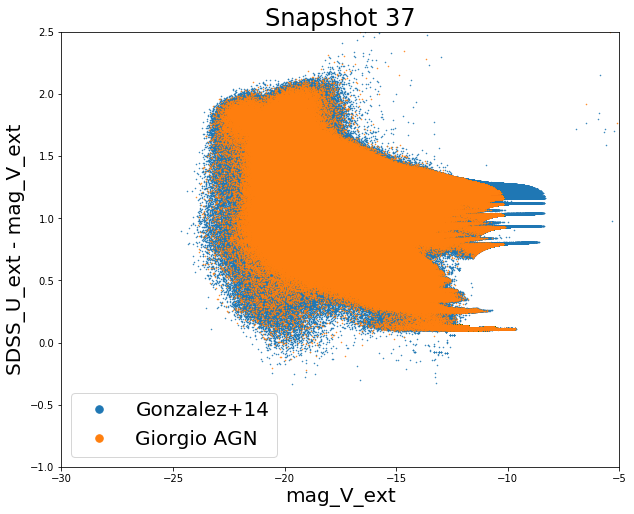

In [25]:
plt.figure(figsize=(10,8))
plt.plot(ALL37['mag_V_ext'],ALL37['SDSS_u_ext']-ALL37['mag_V_ext'],".",markersize=1,label='Gonzalez+14')
plt.plot(v37_tot_feed,u37_tot_feed-v37_tot_feed,".",markersize=1,label='Giorgio AGN')
plt.xlim(-30,-5)
plt.ylim(-1,2.5)
plt.title('Snapshot 37')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=15)
plt.savefig('./plots/colmag37_comparison.png')
plt.show()

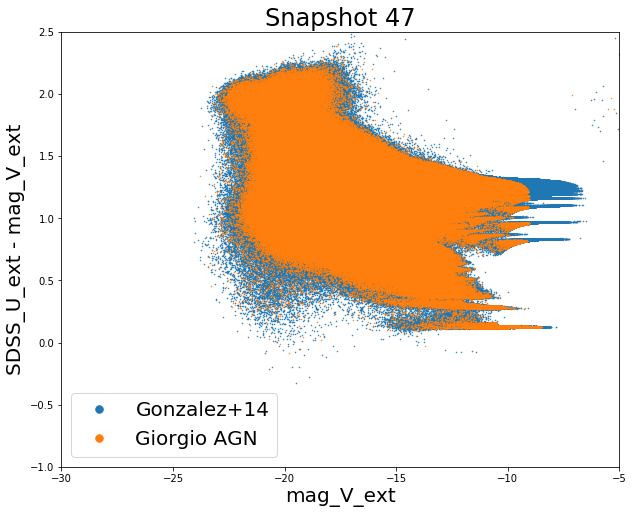

In [51]:
plt.figure(figsize=(10,8))
plt.plot(ALL47['mag_V_ext'],ALL47['SDSS_u_ext']-ALL47['mag_V_ext'],".",markersize=1,label='Gonzalez+14')
plt.plot(v47_tot_feed,u47_tot_feed-v47_tot_feed,".",markersize=1,label='Giorgio AGN')
plt.xlim(-30,-5)
plt.ylim(-1,2.5)
plt.title('Snapshot 47')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=15)
#plt.savefig('./plots/colmag47_comparison.png')
plt.show()

# Try cut 22.5 on both

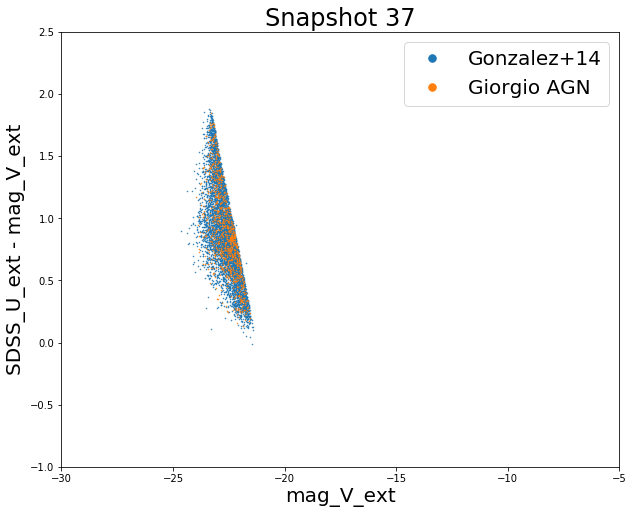

In [26]:
sec37_vio = np.where(ALL37['SDSS_i_obs_ext']<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734))
sec37_gio= np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734))

plt.figure(figsize=(10,8))
plt.plot(np.array(ALL37['mag_V_ext'])[sec37_vio],np.array(ALL37['SDSS_u_ext'])[sec37_vio]-np.array(ALL37['mag_V_ext'])[sec37_vio],".",markersize=1,label='Gonzalez+14')
plt.plot(v37_tot_feed[sec37_gio],u37_tot_feed[sec37_gio]-v37_tot_feed[sec37_gio],".",markersize=1, label='Giorgio AGN')
plt.xlim(-30,-5)
plt.ylim(-1,2.5)
plt.title('Snapshot 37')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=15)
#plt.savefig('./plots/colmag37_comparison_cut225.png')
plt.show()

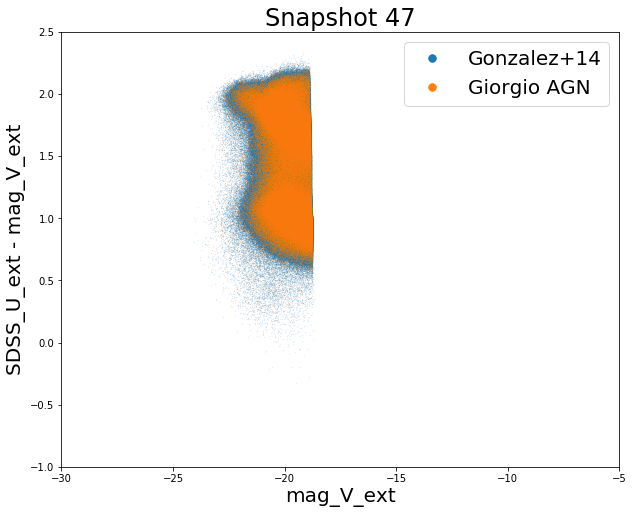

In [27]:
sec47_vio = np.where(ALL47['SDSS_i_obs_ext']<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))
sec47_gio= np.where(i47_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))

plt.figure(figsize=(10,8))
plt.plot(np.array(ALL47['mag_V_ext'])[sec47_vio],np.array(ALL47['SDSS_u_ext'])[sec47_vio]-np.array(ALL47['mag_V_ext'])[sec47_vio],".",markersize=0.1,label='Gonzalez+14')
plt.plot(v47_tot_feed[sec47_gio],u47_tot_feed[sec47_gio]-v47_tot_feed[sec47_gio],".",markersize=0.1,label='Giorgio AGN')
plt.xlim(-30,-5)
plt.ylim(-1,2.5)
plt.title('Snapshot 47')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=150)
#plt.savefig('./plots/colmag47_comparison_cut225.png')
plt.show()

In [1]:
2+2

4

# Comparison LUMINOSITY FUNCTIONS

# READ VIPERS

In [29]:
vipers = pd.read_csv('./vipers_uv.txt',delimiter=' ',header=0,skip_blank_lines=False)
U_vip = np.array(vipers['U'])
V_vip = np.array(vipers['V'])
Z_vip = np.array(vipers['z'])

vip_0405 = np.where((Z_vip>0.4)&(Z_vip<=0.5))
vip_1013 = np.where((Z_vip>1.0)&(Z_vip<=1.3))

# VIPERS low z / VIPERS high z

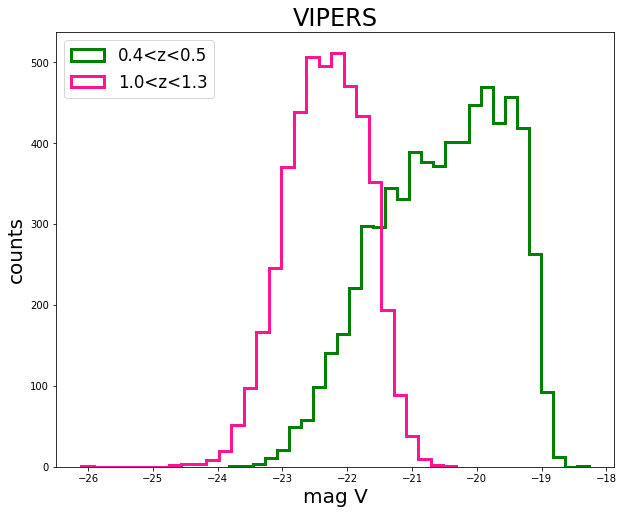

In [30]:
plt.figure(figsize=(10,8))
plt.hist(V_vip[vip_0405],bins=30,histtype='step',lw=3,label='0.4<z<0.5',color='green')
plt.hist(V_vip[vip_1013],bins=30,histtype='step',lw=3,label='1.0<z<1.3',color='deeppink')
plt.xlabel('mag V')
plt.ylabel('counts')
plt.title('VIPERS')
plt.legend(fontsize='small',loc=2)
plt.show()

# VIPERS / GIORGIO AGN

## low redshift

-20.44809913635254
-19.687817000000003
-0.7602821363525365


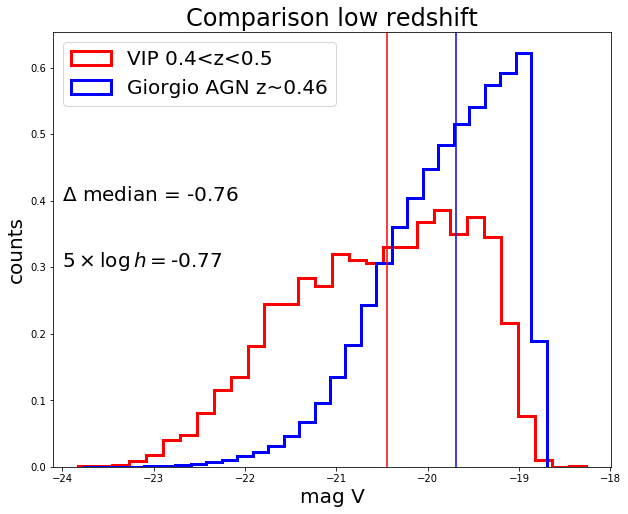

-0.7745097999287159


In [75]:
plt.figure(figsize=(10,8))
sec47 = np.where(i47_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))
plt.hist(V_vip[vip_0405],bins=30,histtype='step',lw=3,density=True,label='VIP 0.4<z<0.5',color='red')
plt.hist(v47_tot_feed[sec47],bins=30,histtype='step',lw=3,density=True,label='Giorgio AGN z~0.46',color='blue')
print(np.median(V_vip[vip_0405]))
print(np.median(v47_tot_feed[sec47]))
delta = np.median(V_vip[vip_0405]) - np.median(v47_tot_feed[sec47]) 
print(delta)
plt.axvline(np.median(V_vip[vip_0405]),color='red')
plt.axvline(np.median(v47_tot_feed[sec47]),color='blue')
plt.xlabel('mag V')
plt.ylabel('counts')
plt.title('Comparison low redshift')
plt.text(-24,0.4,r'$\Delta$ median = '+str(round(delta,2)))
plt.text(-24,0.3,r'$5\times \log\, h = $'+str(round(5*np.log10(0.7),2)))
plt.legend()
plt.savefig('./plots/comparison_luminosity_function_low_z.png')
plt.show()
print(5*np.log10(0.7))

-20.44809913635254
-20.462326799928718


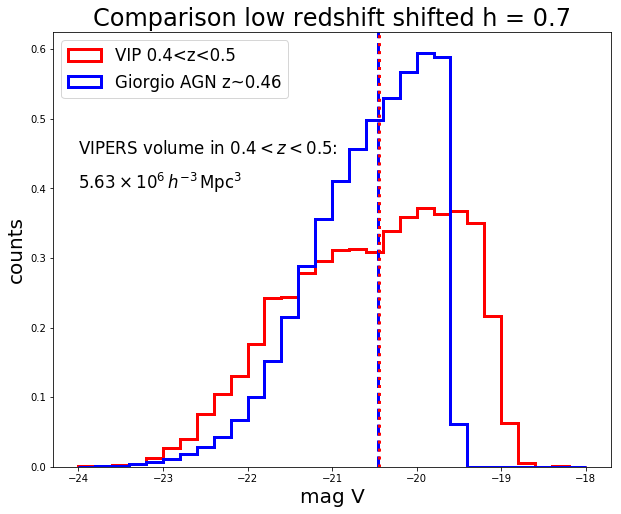

In [85]:
fivelogh = 5*np.log10(0.7)

plt.figure(figsize=(10,8))
plt.hist(V_vip[vip_0405],bins=30,histtype='step',lw=3,density=True,label='VIP 0.4<z<0.5',color='red',range=(-24,-18))
plt.hist(v47_tot_feed[sec47]+fivelogh,bins=30,histtype='step',lw=3,density=True,label='Giorgio AGN z~0.46',color='blue',range=(-24,-18))
print(np.median(V_vip[vip_0405]))
print(np.median(v47_tot_feed[sec47]+fivelogh))
plt.axvline(np.median(v47_tot_feed[sec47])+fivelogh,color='blue',lw=3,ls='--')
plt.axvline(np.median(V_vip[vip_0405]),color='red',lw=3,ls=':')
plt.title('Comparison low redshift shifted h = 0.7')
plt.legend(fontsize='small',loc=2)
plt.xlabel('mag V')
plt.ylabel('counts')
plt.text(-24.,0.45,r'VIPERS volume in $0.4 < z < 0.5$:',fontsize='small')
plt.text(-24.,0.4,r'$5.63 \times 10^6 \, h^{-3}\, \rm{Mpc}^3$ ',fontsize='small')
plt.savefig('./plots/comparison_luminosity_function_low_z_shifted.png')
plt.show()

# VIPERS / GIORGIO NO AGN

-20.44809913635254
-20.111742
-0.3363571363525395


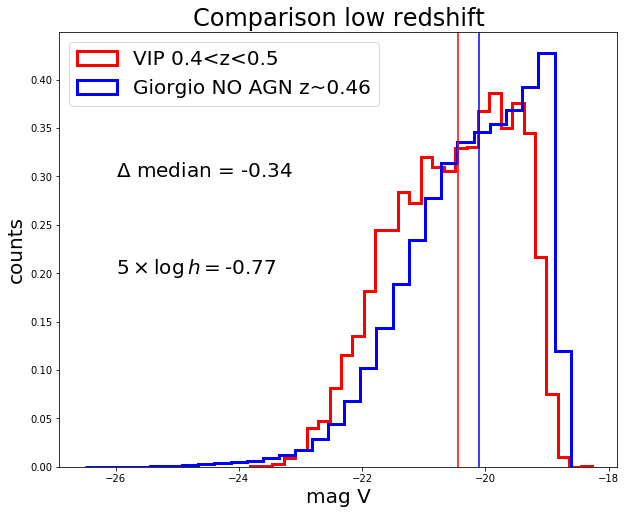

-0.7745097999287159


In [108]:
plt.figure(figsize=(10,8))
sec47 = np.where(i47_tot_nofeed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))
plt.hist(V_vip[vip_0405],bins=30,histtype='step',lw=3,density=True,label='VIP 0.4<z<0.5',color='red')
plt.hist(v47_tot_nofeed[sec47],bins=30,histtype='step',lw=3,density=True,label='Giorgio NO AGN z~0.46',color='blue')
print(np.median(V_vip[vip_0405]))
print(np.median(v47_tot_nofeed[sec47]))
delta = np.median(V_vip[vip_0405]) - np.median(v47_tot_nofeed[sec47]) 
print(delta)
plt.axvline(np.median(V_vip[vip_0405]),color='red')
plt.axvline(np.median(v47_tot_nofeed[sec47]),color='blue')
plt.xlabel('mag V')
plt.ylabel('counts')
plt.title('Comparison low redshift')
plt.text(-26,0.3,r'$\Delta$ median = '+str(round(delta,2)))
plt.text(-26,0.2,r'$5\times \log\, h = $'+str(round(5*np.log10(0.7),2)))
plt.legend()
#plt.savefig('./plots/comparison_luminosity_function_low_z_NOAGN.png')
plt.show()
print(5*np.log10(0.7))

-20.44809913635254
-20.886251799928715
0.4381526635761759


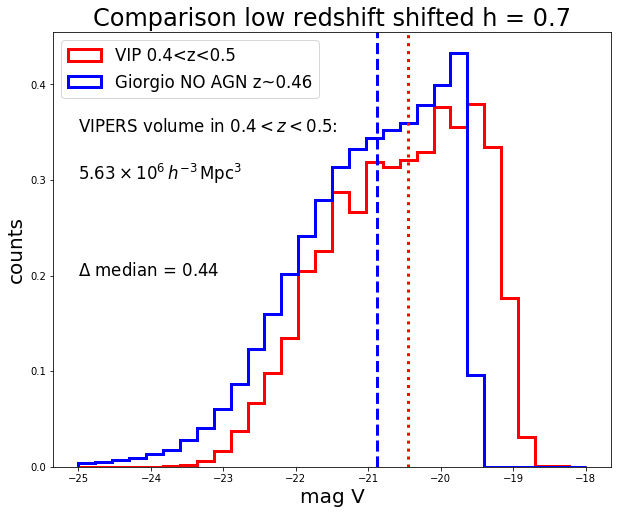

In [94]:
fivelogh = 5*np.log10(0.7)

plt.figure(figsize=(10,8))
plt.hist(V_vip[vip_0405],bins=30,histtype='step',lw=3,density=True,label='VIP 0.4<z<0.5',color='red',range=(-25,-18))
plt.hist(v47_tot_nofeed[sec47]+fivelogh,bins=30,histtype='step',lw=3,density=True,label='Giorgio NO AGN z~0.46',color='blue',range=(-25,-18))
print(np.median(V_vip[vip_0405]))
print(np.median(v47_tot_nofeed[sec47]+fivelogh))
plt.axvline(np.median(v47_tot_nofeed[sec47])+fivelogh,color='blue',lw=3,ls='--')
plt.axvline(np.median(V_vip[vip_0405]),color='red',lw=3,ls=':')
delta = np.median(V_vip[vip_0405]) - np.median(v47_tot_nofeed[sec47]+fivelogh) 
print(delta)
plt.title('Comparison low redshift shifted h = 0.7')
plt.legend(fontsize='small',loc=2)
plt.xlabel('mag V')
plt.ylabel('counts')
plt.text(-25.,0.35,r'VIPERS volume in $0.4 < z < 0.5$:',fontsize='small')
plt.text(-25.,0.3,r'$5.63 \times 10^6 \, h^{-3}\, \rm{Mpc}^3$ ',fontsize='small')
plt.text(-25.,0.2,r'$\Delta$ median = '+str(round(delta,2)),fontsize='small')
plt.savefig('./plots/comparison_luminosity_function_low_z_shifted_NOAGN.png')
plt.show()

# HIGH REDSHIFT

-22.306100845336914
-22.325888
0.019787154663085005


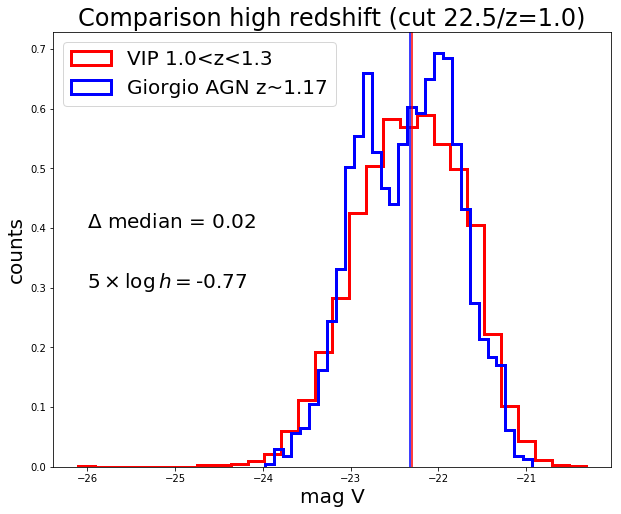

-0.7745097999287159


In [109]:
plt.figure(figsize=(10,8))
sec37 = np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.))
plt.hist(V_vip[vip_1013],bins=30,histtype='step',lw=3,density=True,label='VIP 1.0<z<1.3',color='red')
plt.hist(v37_tot_feed[sec37],bins=30,histtype='step',lw=3,density=True,label='Giorgio AGN z~1.17',color='blue')
print(np.median(V_vip[vip_1013]))
print(np.median(v37_tot_feed[sec37]))
delta = np.median(V_vip[vip_1013]) - np.median(v37_tot_feed[sec37]) 
print(delta)
plt.axvline(np.median(V_vip[vip_1013]),color='red')
plt.axvline(np.median(v37_tot_feed[sec37]),color='blue')
plt.xlabel('mag V')
plt.ylabel('counts')
plt.title('Comparison high redshift (cut 22.5/z=1.0)')
plt.text(-26,0.4,r'$\Delta$ median = '+str(round(delta,2)))
plt.text(-26,0.3,r'$5\times \log\, h = $'+str(round(5*np.log10(0.7),2)))
plt.legend()
plt.savefig('./plots/comparison_luminosity_function_high_z.png')
plt.show()
print(5*np.log10(0.7))

-22.306100845336914
-23.100397799928714
0.7942969545918004


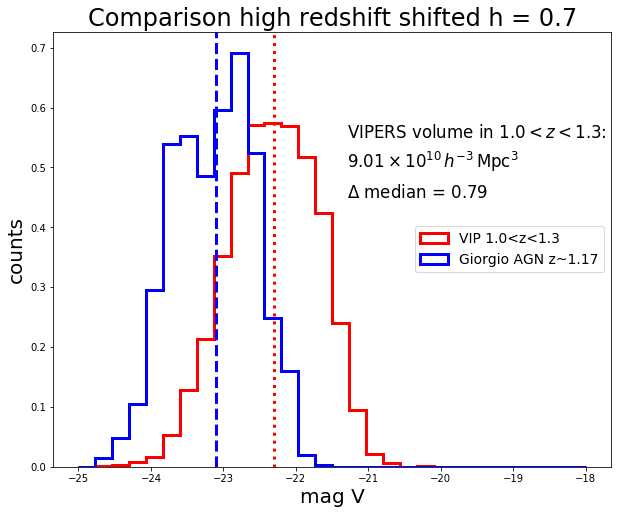

In [125]:
fivelogh = 5*np.log10(0.7)
sec37 = np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.))
plt.figure(figsize=(10,8))
plt.hist(V_vip[vip_1013],bins=30,histtype='step',lw=3,density=True,label='VIP 1.0<z<1.3',color='red',range=(-25,-18))
plt.hist(v37_tot_feed[sec37]+fivelogh,bins=30,histtype='step',lw=3,density=True,label='Giorgio AGN z~1.17',color='blue',range=(-25,-18))
print(np.median(V_vip[vip_1013]))
print(np.median(v37_tot_feed[sec37]+fivelogh))
plt.axvline(np.median(v37_tot_feed[sec37])+fivelogh,color='blue',lw=3,ls='--')
plt.axvline(np.median(V_vip[vip_1013]),color='red',lw=3,ls=':')
delta = np.median(V_vip[vip_1013]) - np.median(v37_tot_feed[sec37]+fivelogh) 
print(delta)
plt.title('Comparison high redshift shifted h = 0.7')
plt.legend(fontsize='x-small',loc=5)
plt.xlabel('mag V')
plt.ylabel('counts')
plt.text(-21.3,0.55,r'VIPERS volume in $1.0 < z < 1.3$:',fontsize='small')
plt.text(-21.3,0.5,r'$9.01 \times 10^{10} \, h^{-3}\, \rm{Mpc}^3$ ',fontsize='small')
plt.text(-21.3,0.45,r'$\Delta$ median = '+str(round(delta,2)),fontsize='small')
plt.savefig('./plots/comparison_luminosity_function_high_z_shifted.png')
plt.show()

-22.306100845336914
-22.57001
0.26390915466308584


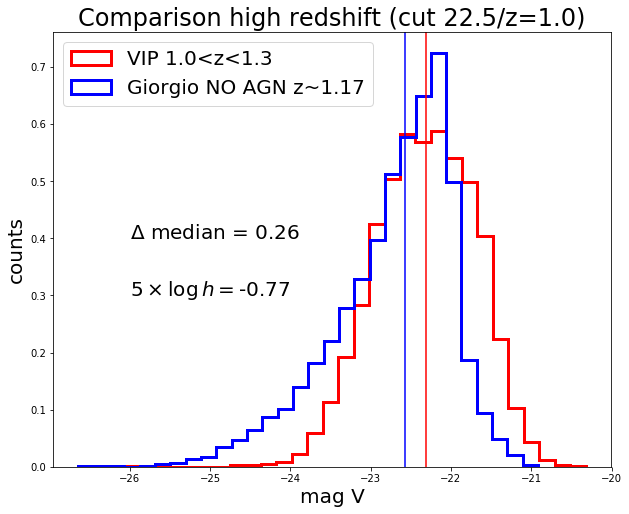

-0.7745097999287159


In [127]:
plt.figure(figsize=(10,8))
sec37 = np.where(i37_tot_nofeed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.))
plt.hist(V_vip[vip_1013],bins=30,histtype='step',lw=3,density=True,label='VIP 1.0<z<1.3',color='red')
plt.hist(v37_tot_nofeed[sec37],bins=30,histtype='step',lw=3,density=True,label='Giorgio NO AGN z~1.17',color='blue')
print(np.median(V_vip[vip_1013]))
print(np.median(v37_tot_nofeed[sec37]))
delta = np.median(V_vip[vip_1013]) - np.median(v37_tot_nofeed[sec37]) 
print(delta)
plt.axvline(np.median(V_vip[vip_1013]),color='red')
plt.axvline(np.median(v37_tot_nofeed[sec37]),color='blue')
plt.xlabel('mag V')
plt.ylabel('counts')
plt.title('Comparison high redshift (cut 22.5/z=1.0)')
plt.text(-26,0.4,r'$\Delta$ median = '+str(round(delta,2)))
plt.text(-26,0.3,r'$5\times \log\, h = $'+str(round(5*np.log10(0.7),2)))
plt.legend()
plt.savefig('./plots/comparison_luminosity_function_high_z_NOAGN.png')
plt.show()
print(5*np.log10(0.7))

-22.306100845336914
-23.344519799928715
1.0384189545918012


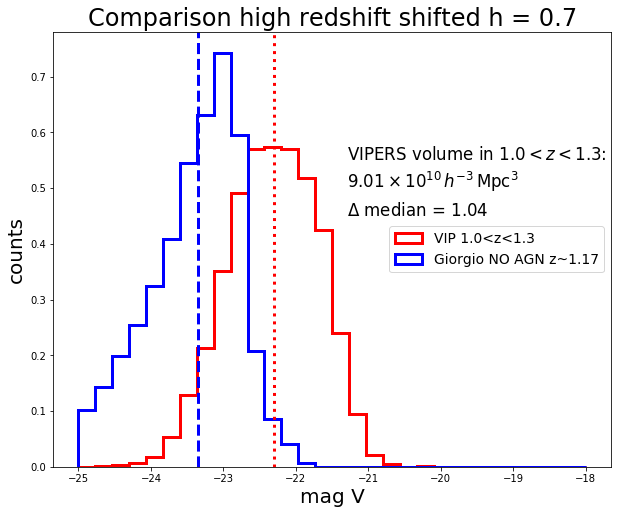

In [129]:
fivelogh = 5*np.log10(0.7)
sec37 = np.where(i37_tot_nofeed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.))
plt.figure(figsize=(10,8))
plt.hist(V_vip[vip_1013],bins=30,histtype='step',lw=3,density=True,label='VIP 1.0<z<1.3',color='red',range=(-25,-18))
plt.hist(v37_tot_nofeed[sec37]+fivelogh,bins=30,histtype='step',lw=3,density=True,label='Giorgio NO AGN z~1.17',color='blue',range=(-25,-18))
print(np.median(V_vip[vip_1013]))
print(np.median(v37_tot_nofeed[sec37]+fivelogh))
plt.axvline(np.median(v37_tot_nofeed[sec37])+fivelogh,color='blue',lw=3,ls='--')
plt.axvline(np.median(V_vip[vip_1013]),color='red',lw=3,ls=':')
delta = np.median(V_vip[vip_1013]) - np.median(v37_tot_nofeed[sec37]+fivelogh) 
print(delta)
plt.title('Comparison high redshift shifted h = 0.7')
plt.legend(fontsize='x-small',loc=5)
plt.xlabel('mag V')
plt.ylabel('counts')
plt.text(-21.3,0.55,r'VIPERS volume in $1.0 < z < 1.3$:',fontsize='small')
plt.text(-21.3,0.5,r'$9.01 \times 10^{10} \, h^{-3}\, \rm{Mpc}^3$ ',fontsize='small')
plt.text(-21.3,0.45,r'$\Delta$ median = '+str(round(delta,2)),fontsize='small')
plt.savefig('./plots/comparison_luminosity_function_high_z_shifted_NOAGN.png')
plt.show()

Computing...
colour_bin 	 bin_size
0.55 	 0.45000000000000023
0.71 	 0.15
0.86 	 0.03
1.02 	 0.01
1.17 	 0.03
1.33 	 0.05
1.48 	 0.04
1.64 	 0.02
1.79 	 0.02
1.95 	 0.02
...done.
Computing...
colour_bin 	 bin_size
0.55 	 0.12999999999999998
0.71 	 0.03
0.86 	 0.01
1.02 	 0.01
1.17 	 0.01
1.33 	 0.01
1.48 	 0.01
1.64 	 0.01
1.79 	 0.02
1.95 	 0.01
...done.


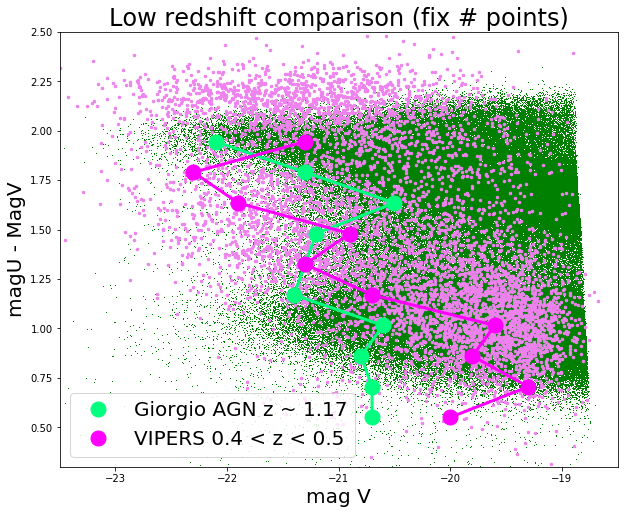

In [172]:
plt.figure(figsize=(10,8))

sec47 = np.where(i47_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))
plt.plot(v47_tot_feed[sec47],u47_tot_feed[sec47]-v47_tot_feed[sec47],",",color='green')
plt.plot(V_vip[vip_0405],U_vip[vip_0405]-V_vip[vip_0405],".",markersize=5,color='violet')

#GALFORM
e47_x,e47_y = EDGE_fixed_Npoints(v47_tot_feed[sec47],u47_tot_feed[sec47]-v47_tot_feed[sec47],y_points_per_bin=5000,y_Nbins=10)
#e47_x,e47_y = EDGE(v47_tot_feed[sec47],u47_tot_feed[sec47]-v47_tot_feed[sec47])
plt.plot(e47_x,e47_y,".",markersize=30,color='springgreen',label='Giorgio AGN z ~ 0.46')
plt.plot(e47_x,e47_y,"-",lw=3,color='springgreen')

#VIPERS
v47_x,v47_y = EDGE_fixed_Npoints(V_vip[vip_0405],U_vip[vip_0405]-V_vip[vip_0405],y_points_per_bin=30,y_Nbins=10)
#v47_x,v47_y = EDGE(V_vip[vip_0405],U_vip[vip_0405]-V_vip[vip_0405])
plt.plot(v47_x,v47_y,".",markersize=30,color='fuchsia',label='VIPERS 0.4 < z < 0.5')
plt.plot(v47_x,v47_y,"-",lw=3,color='fuchsia')

plt.xlim(-23.5,-18.5)
plt.ylim(0.3,2.5)

plt.xlabel('mag V')
plt.ylabel('magU - MagV')
plt.title('Low redshift comparison (fix # points)')
plt.legend()
plt.savefig('./plots/VIPERS_overposed_low_z_fixpoints.png')

plt.show()

#sec37= np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.0))
#plt.plot(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],".")
#plt.plot(V_vip[vip_1013],U_vip[vip_1013]-V_vip[vip_1013],",")

# Define a function to plot the colour magnitude

In [47]:
def colmag_cut_single(v_gal=v47_tot_feed,
               u_gal=u47_tot_feed,
               i_gal=i47_tot_feed,
               z_gal_cut = 0.456 ,
               v_vipers=V_vip[vip_0405],
               u_vipers=U_vip[vip_0405],
               title='Low redshift comparison ',
               label_gal = 'Giorgio AGN z ~ 0.46',
               label_vip = 'VIPERS 0.4 < z < 0.5',
               path_fig='./plots/VIPERS_overposed_low_z_fixpoints.png',
               save_fig=False,
               xbsz=0.1,
               ybsz=0.1,
               thr=0.15,
               fix_point=False,
               Npoints_gal=5000,
               Npoints_vip=30,
               N_colour_bins=10):


    plt.figure(figsize=(10,8))

    sec_gal = np.where(i_gal<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=z_gal_cut))
    plt.plot(v_gal[sec_gal],u_gal[sec_gal]-v_gal[sec_gal],",",color='green')
    plt.plot(v_vipers,u_vipers-v_vipers,".",markersize=5,color='violet')

    #GALFORM
    if fix_point:
        e47_x,e47_y = EDGE_fixed_Npoints(v_gal[sec_gal],u_gal[sec_gal]-v_gal[sec_gal],y_points_per_bin=Npoints_gal,y_Nbins=N_colour_bins)
        lbl = '(fix # points)'
    else:
        e47_x,e47_y = EDGE(v_gal[sec_gal],u_gal[sec_gal]-v_gal[sec_gal],y_bin_size=ybsz,x_bin_size=xbsz,threashold=thr)
        lbl='(usual method)'

    plt.plot(e47_x,e47_y,".",markersize=30,color='springgreen',label=label_gal)
    plt.plot(e47_x,e47_y,"-",lw=3,color='springgreen')

    #VIPERS
    if fix_point:
        v47_x,v47_y = EDGE_fixed_Npoints(v_vipers,u_vipers-v_vipers,y_points_per_bin=Npoints_vip,y_Nbins=N_colour_bins)
        lbl = '(fix # points)'
    else:
        v47_x,v47_y = EDGE(v_vipers,u_vipers-v_vipers,y_bin_size=ybsz,x_bin_size=xbsz,threashold=thr)
        lbl='(usual method)'

    plt.plot(v47_x,v47_y,".",markersize=30,color='fuchsia',label=label_vip)
    plt.plot(v47_x,v47_y,"-",lw=3,color='fuchsia')

    plt.xlim(-23.5,-18.5)
    plt.ylim(0.3,2.5)

    plt.xlabel('mag V')
    plt.ylabel('magU - MagV')
    plt.title(title+lbl)
    plt.legend()
    if save_fig:
        plt.savefig(path_fig)

    plt.show()

# Low redshift usual method

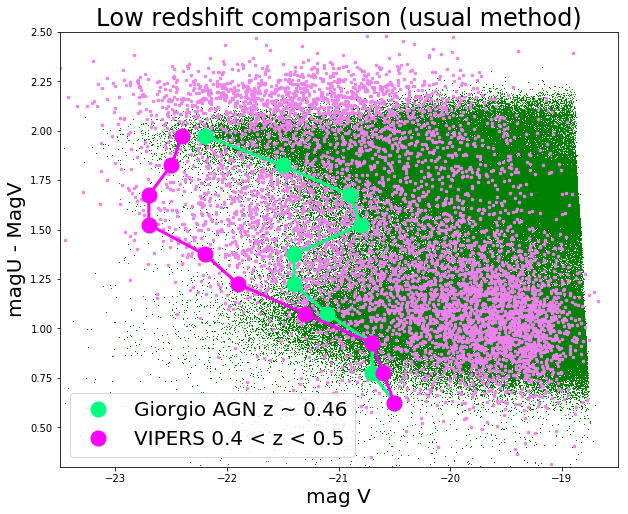

In [56]:
colmag_cut_single(v_gal=v47_tot_feed,
               u_gal=u47_tot_feed,
               i_gal=i47_tot_feed,
               z_gal_cut = 0.456 ,
               v_vipers=V_vip[vip_0405],
               u_vipers=U_vip[vip_0405],
               title='Low redshift comparison ',
               label_gal = 'Giorgio AGN z ~ 0.46',
               label_vip = 'VIPERS 0.4 < z < 0.5',
               path_fig='./plots/VIPERS_overposed_low_z.png',
               save_fig=True,
               xbsz=0.1,
               ybsz=0.15,
               thr=0.15,
               fix_point=False,
               Npoints_gal=5000,
               Npoints_vip=30,
               N_colour_bins=10)

# Low redshift fix points

Computing...
colour_bin 	 bin_size
0.55 	 0.45000000000000023
0.71 	 0.15
0.86 	 0.03
1.02 	 0.01
1.17 	 0.03
1.33 	 0.05
1.48 	 0.04
1.64 	 0.02
1.79 	 0.02
1.95 	 0.02
...done.
Computing...
colour_bin 	 bin_size
0.55 	 0.12999999999999998
0.71 	 0.03
0.86 	 0.01
1.02 	 0.01
1.17 	 0.01
1.33 	 0.01
1.48 	 0.01
1.64 	 0.01
1.79 	 0.02
1.95 	 0.01
...done.


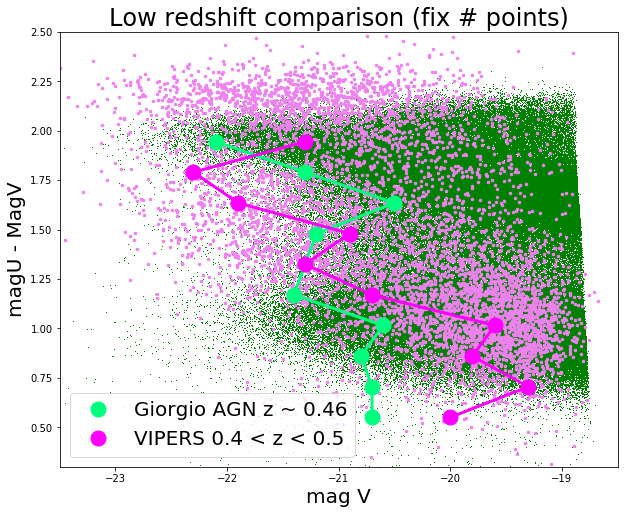

In [54]:
colmag_cut_single(v_gal=v47_tot_feed,
               u_gal=u47_tot_feed,
               i_gal=i47_tot_feed,
               z_gal_cut = 0.456 ,
               v_vipers=V_vip[vip_0405],
               u_vipers=U_vip[vip_0405],
               title='Low redshift comparison ',
               label_gal = 'Giorgio AGN z ~ 0.46',
               label_vip = 'VIPERS 0.4 < z < 0.5',
               path_fig='./plots/VIPERS_overposed_low_z_fixpoints.png',
               save_fig=True,
               xbsz=0.1,
               ybsz=0.1,
               thr=0.15,
               fix_point=True,
               Npoints_gal=5000,
               Npoints_vip=30,
               N_colour_bins=10)

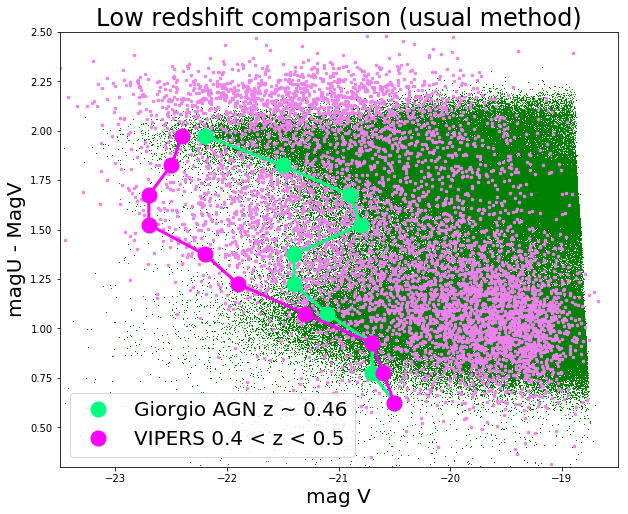

In [32]:
plt.figure(figsize=(10,8))

sec47 = np.where(i47_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))
plt.plot(v47_tot_feed[sec47],u47_tot_feed[sec47]-v47_tot_feed[sec47],",",color='green')
plt.plot(V_vip[vip_0405],U_vip[vip_0405]-V_vip[vip_0405],".",markersize=5,color='violet')

#GALFORM
#e47_x,e47_y = EDGE_fixed_Npoints(v47_tot_feed[sec47],u47_tot_feed[sec47]-v47_tot_feed[sec47],y_points_per_bin=5000,y_Nbins=10)
e47_x,e47_y = EDGE(v47_tot_feed[sec47],u47_tot_feed[sec47]-v47_tot_feed[sec47])
plt.plot(e47_x,e47_y,".",markersize=30,color='springgreen',label='Giorgio AGN z ~ 0.46')
plt.plot(e47_x,e47_y,"-",lw=3,color='springgreen')

#VIPERS
#v47_x,v47_y = EDGE_fixed_Npoints(V_vip[vip_0405],U_vip[vip_0405]-V_vip[vip_0405],y_points_per_bin=30,y_Nbins=10)
v47_x,v47_y = EDGE(V_vip[vip_0405],U_vip[vip_0405]-V_vip[vip_0405])
plt.plot(v47_x,v47_y,".",markersize=30,color='fuchsia',label='VIPERS 0.4 < z < 0.5')
plt.plot(v47_x,v47_y,"-",lw=3,color='fuchsia')

plt.xlim(-23.5,-18.5)
plt.ylim(0.3,2.5)

plt.xlabel('mag V')
plt.ylabel('magU - MagV')
plt.title('Low redshift comparison (usual method)')
plt.legend()

plt.savefig('./plots/VIPERS_overposed_low_z.png')
plt.show()

#sec37= np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.0))
#plt.plot(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],".")
#plt.plot(V_vip[vip_1013],U_vip[vip_1013]-V_vip[vip_1013],",")

Computing...
colour_bin 	 bin_size
0.1 	 0.24000000000000007
0.3 	 0.05
0.5 	 0.02
0.7 	 0.02
0.9 	 0.02
1.1 	 0.04
1.3 	 0.04
1.5 	 0.04
1.7 	 0.03
1.9 	 0.13999999999999999
...done.
Computing...
colour_bin 	 bin_size
0.1 	 0.17
0.3 	 0.060000000000000005
0.5 	 0.03
0.7 	 0.02
0.9 	 0.02
1.1 	 0.02
1.3 	 0.03
1.5 	 0.03
1.7 	 0.03
1.9 	 0.03
...done.


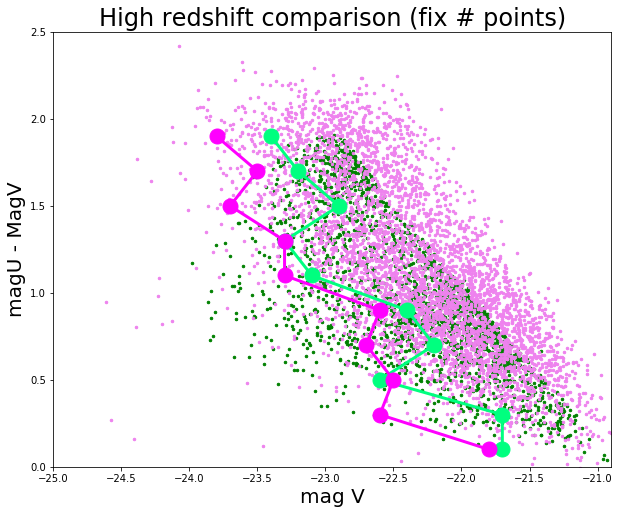

In [186]:
plt.figure(figsize=(10,8))

sec37 = np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.))
plt.plot(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],".",markersize=5,color='green')
plt.plot(V_vip[vip_1013],U_vip[vip_1013]-V_vip[vip_1013],".",markersize=5,color='violet')

#GALFORM
e37_x,e37_y = EDGE_fixed_Npoints(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],y_points_per_bin=30,y_Nbins=10,y_min=0.1)
#e47_x,e47_y = EDGE(v47_tot_feed[sec47],u47_tot_feed[sec47]-v47_tot_feed[sec47])
plt.plot(e37_x,e37_y,".",markersize=30,color='springgreen')
plt.plot(e37_x,e37_y,"-",lw=3,color='springgreen')

#VIPERS
v37_x,v37_y = EDGE_fixed_Npoints(V_vip[vip_1013],U_vip[vip_1013]-V_vip[vip_1013],y_points_per_bin=40,y_Nbins=10,y_min=0.1)
#v47_x,v47_y = EDGE(V_vip[vip_0405],U_vip[vip_0405]-V_vip[vip_0405])
plt.plot(v37_x,v37_y,".",markersize=30,color='fuchsia',label='VIPERS 1.0 < z < 1.3')
plt.plot(v37_x,v37_y,"-",lw=3,color='fuchsia')

plt.xlim(-25.,-20.9)
plt.ylim(0.,2.5)

plt.xlabel('mag V')
plt.ylabel('magU - MagV')
plt.title('High redshift comparison (fix # points)')
plt.savefig('./plots/VIPERS_overposed_high_z_fixpoints.png')

plt.show()

#sec37= np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.0))
#plt.plot(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],".")
#plt.plot(V_vip[vip_1013],U_vip[vip_1013]-V_vip[vip_1013],",")

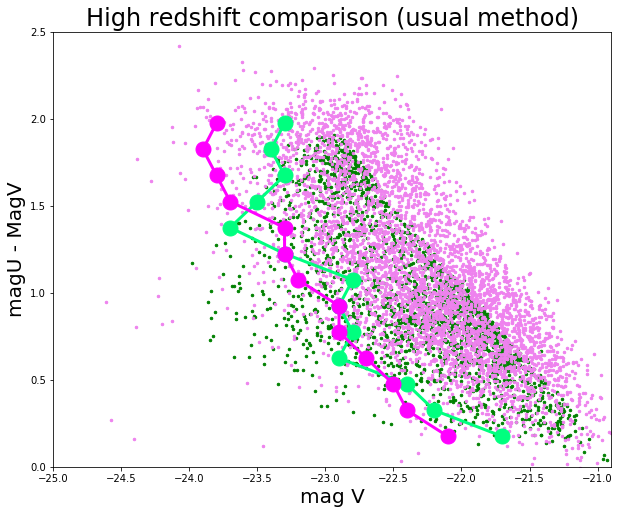

In [31]:
plt.figure(figsize=(10,8))

sec37 = np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.))
plt.plot(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],".",markersize=5,color='green')
plt.plot(V_vip[vip_1013],U_vip[vip_1013]-V_vip[vip_1013],".",markersize=5,color='violet')

#GALFORM
#e37_x,e37_y = EDGE_fixed_Npoints(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],y_points_per_bin=20,y_Nbins=10)
e37_x,e37_y = EDGE(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],y_min=0.1)
plt.plot(e37_x,e37_y,".",markersize=30,color='springgreen')
plt.plot(e37_x,e37_y,"-",lw=3,color='springgreen')

#VIPERS
#v37_x,v37_y = EDGE_fixed_Npoints(V_vip[vip_1013],U_vip[vip_1013]-V_vip[vip_1013],y_points_per_bin=30,y_Nbins=10)
v37_x,v37_y = EDGE(V_vip[vip_1013],U_vip[vip_1013]-V_vip[vip_1013],y_min=0.1)
plt.plot(v37_x,v37_y,".",markersize=30,color='fuchsia',label='VIPERS 0.4 < z < 0.5')
plt.plot(v37_x,v37_y,"-",lw=3,color='fuchsia')

plt.xlim(-25.,-20.9)
plt.ylim(0.,2.5)

plt.xlabel('mag V')
plt.ylabel('magU - MagV')
plt.title('High redshift comparison (usual method)')
#plt.savefig('./plots/VIPERS_overposed_high_z.png')
plt.show()

#sec37= np.where(i37_tot_feed<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.0))
#plt.plot(v37_tot_feed[sec37],u37_tot_feed[sec37]-v37_tot_feed[sec37],".")
#plt.plot(V_vip[vip_1013],U_vip[vip_1013]-V_vip[vip_1013],",")

In [1]:
2+2

4